In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler
from imblearn.over_sampling import SMOTE
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import optuna
from optuna import Trial
from imblearn.combine import SMOTEENN
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import BorderlineSMOTE
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier , GradientBoostingClassifier , ExtraTreesClassifier , VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV , cross_val_score , StratifiedKFold , learning_curve

c:\Users\abeta\anaconda3\envs\forcompe\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_sub = pd.read_csv("sample_submission.csv")
df_ = df.copy()

# EDA

In [4]:
pd.options.display.max_info_columns
df.info(verbose=True)


pd.set_option('display.max_info_columns', 1000) 
pd.set_option('display.max_columns', 1000) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Data columns (total 51 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   171202 non-null  int64  
 1   TARGET                       171202 non-null  int64  
 2   NAME_CONTRACT_TYPE           171202 non-null  object 
 3   CODE_GENDER                  171202 non-null  object 
 4   FLAG_OWN_CAR                 136961 non-null  object 
 5   FLAG_OWN_REALTY              136961 non-null  object 
 6   CNT_CHILDREN                 171202 non-null  int64  
 7   AMT_INCOME_TOTAL             171202 non-null  float64
 8   AMT_CREDIT                   171202 non-null  float64
 9   AMT_ANNUITY                  171196 non-null  float64
 10  AMT_GOODS_PRICE              171039 non-null  float64
 11  NAME_TYPE_SUITE              170455 non-null  object 
 12  NAME_INCOME_TYPE             171202 non-null  object 
 13 

In [5]:
intcolumns = df_.select_dtypes("int").columns
floatcolumns = df_.select_dtypes("float").columns
df[intcolumns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   SK_ID_CURR                   171202 non-null  int64
 1   TARGET                       171202 non-null  int64
 2   CNT_CHILDREN                 171202 non-null  int64
 3   DAYS_BIRTH                   171202 non-null  int64
 4   DAYS_EMPLOYED                171202 non-null  int64
 5   DAYS_ID_PUBLISH              171202 non-null  int64
 6   FLAG_MOBIL                   171202 non-null  int64
 7   FLAG_EMP_PHONE               171202 non-null  int64
 8   FLAG_WORK_PHONE              171202 non-null  int64
 9   FLAG_CONT_MOBILE             171202 non-null  int64
 10  FLAG_PHONE                   171202 non-null  int64
 11  FLAG_EMAIL                   171202 non-null  int64
 12  REGION_RATING_CLIENT         171202 non-null  int64
 13  REGION_RATING_CLIENT_W_CITY  

In [15]:
df[floatcolumns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AMT_INCOME_TOTAL            171202 non-null  float64
 1   AMT_CREDIT                  171202 non-null  float64
 2   AMT_ANNUITY                 171196 non-null  float64
 3   AMT_GOODS_PRICE             171039 non-null  float64
 4   REGION_POPULATION_RELATIVE  171202 non-null  float64
 5   DAYS_REGISTRATION           171202 non-null  float64
 6   OWN_CAR_AGE                 58210 non-null   float64
 7   CNT_FAM_MEMBERS             171200 non-null  float64
 8   EXT_SOURCE_1                52274 non-null   float64
 9   EXT_SOURCE_2                170833 non-null  float64
 10  EXT_SOURCE_3                116616 non-null  float64
 11  OBS_30_CNT_SOCIAL_CIRCLE    170642 non-null  float64
 12  DEF_30_CNT_SOCIAL_CIRCLE    170642 non-null  float64
 13  OBS_60_CNT_SOC

In [60]:
df.tail(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
171197,171197,0,Cash loans,M,NaN,NaN,0,83250.0,404325.0,20772.0,337500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.031329,-20529,-3059,-11581.0,-3689,21.0,1,1,1,1,0,0,Laborers,2.0,2,2,0,0,0,0,1,1,Agriculture,NaN,0.404560,0.768808,0.0,0.0,0.0,0.0,-2341.0,0.0,0.0,1.0,0.0
171198,171198,0,Cash loans,F,Y,Y,0,247500.0,601470.0,29065.5,450000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010006,-22083,-129,-4629.0,-1773,1.0,1,1,0,1,0,0,Cooking staff,1.0,2,1,0,0,0,0,0,0,Industry: type 3,NaN,0.608542,NaN,0.0,0.0,0.0,0.0,-1688.0,0.0,0.0,1.0,5.0
171199,171199,0,Cash loans,F,N,N,2,292500.0,1237684.5,49216.5,1138500.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.006629,-11053,-2536,-4858.0,-3393,NaN,1,1,0,1,0,1,Core staff,4.0,2,2,0,0,0,0,0,0,School,NaN,0.664305,0.758393,2.0,1.0,2.0,1.0,-515.0,0.0,0.0,0.0,1.0
171200,171200,0,Cash loans,M,Y,N,0,112500.0,239850.0,25186.5,225000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.009657,-8505,-165,-3318.0,-1176,7.0,1,1,0,1,0,0,Sales staff,1.0,2,2,0,0,0,1,1,0,Business Entity Type 3,0.210918,0.627050,NaN,0.0,0.0,0.0,0.0,-1133.0,NaN,NaN,NaN,NaN
171201,171201,0,Cash loans,F,NaN,NaN,0,108000.0,161730.0,8595.0,135000.0,Family,Working,Secondary / secondary special,Single / not married,House / apartment,0.007305,-17925,-5209,-2411.0,-1473,NaN,1,1,1,1,1,0,Core staff,1.0,3,3,0,0,0,0,0,0,Kindergarten,NaN,0.517986,0.382502,0.0,0.0,0.0,0.0,-220.0,0.0,0.0,0.0,1.0


In [61]:
df_.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,675000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.010032,-9233,-878,-333.0,-522,NaN,1,1,1,1,0,0,Core staff,2.0,2,2,0,1,1,0,1,1,School,NaN,0.372591,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,1,0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,585000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.008019,-20148,365243,-4469.0,-3436,NaN,1,0,0,1,0,0,NaN,2.0,2,2,0,0,0,0,0,0,XNA,NaN,0.449567,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,2,0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,270000.0,Family,State servant,Secondary / secondary special,Married,House / apartment,0.004960,-18496,-523,-3640.0,-2050,NaN,1,1,1,1,1,0,Core staff,2.0,2,2,0,0,0,0,0,0,Postal,NaN,0.569503,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN
3,3,0,Cash loans,F,N,Y,0,67500.0,152820.0,8901.0,135000.0,Children,Pensioner,Lower secondary,Widow,House / apartment,0.005002,-24177,365243,-4950.0,-3951,NaN,1,0,0,1,1,0,NaN,1.0,3,3,0,0,0,0,0,0,XNA,NaN,0.105235,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,Cash loans,M,N,N,0,157500.0,271066.5,21546.0,234000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,With parents,0.006296,-10685,-697,-5101.0,-3226,NaN,1,1,1,1,0,0,Drivers,2.0,3,3,0,0,0,0,1,1,Business Entity Type 3,0.342344,0.202490,0.669057,0.0,0.0,0.0,0.0,-1243.0,0.0,0.0,0.0,4.0


In [62]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,171202.00000,171202.000000,171202.000000,1.712020e+05,1.712020e+05,171196.000000,1.710390e+05,171202.000000,171202.000000,171202.000000,171202.000000,171202.000000,58210.000000,171202.000000,171202.000000,171202.000000,171202.000000,171202.000000,171202.000000,171200.000000,171202.000000,171202.000000,171202.000000,171202.000000,171202.000000,171202.000000,171202.000000,171202.000000,52274.000000,1.708330e+05,116616.000000,170642.000000,170642.000000,170642.000000,170642.000000,171201.000000,148086.000000,148086.000000,148086.000000,148086.000000
mean,85600.50000,0.080729,0.416490,1.683712e+05,5.991293e+05,27127.500701,5.384669e+05,0.020839,-16045.340504,63960.411969,-4994.982524,-2990.486005,12.024429,0.999994,0.819494,0.199723,0.998312,0.281650,0.057085,2.152331,2.053726,2.032792,0.015204,0.050607,0.040765,0.078399,0.230056,0.179157,0.501692,5.145083e-01,0.511177,1.423137,0.143915,1.406406,0.100438,-962.411218,0.006652,0.268418,0.267547,1.903644
std,49421.90473,0.272420,0.720138,1.072348e+05,4.028170e+05,14538.361801,3.696921e+05,0.013803,4363.792228,141401.513149,3525.760241,1509.694163,11.895017,0.002417,0.384610,0.399793,0.041051,0.449805,0.232005,0.908845,0.508718,0.502538,0.122365,0.219194,0.197745,0.268799,0.420869,0.383485,0.210950,1.912729e-01,0.194778,2.323733,0.443579,2.303540,0.360037,826.278427,0.086204,0.921022,0.914532,1.872237
min,0.00000,0.000000,0.000000,2.610000e+04,4.500000e+04,1980.000000,4.500000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017095,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,-4173.000000,0.000000,0.000000,0.000000,0.000000
25%,42800.25000,0.000000,0.000000,1.125000e+05,2.700000e+05,16546.500000,2.385000e+05,0.010006,-19686.000000,-2772.000000,-7490.000000,-4297.000000,5.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333353,3.920925e-01,0.370650,0.000000,0.000000,0.000000,0.000000,-1568.000000,0.000000,0.000000,0.000000,0.000000
50%,85600.50000,0.000000,0.000000,1.462500e+05,5.146020e+05,24916.500000,4.500000e+05,0.018850,-15778.000000,-1215.000000,-4515.000000,-3247.000000,9.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.505858,5.662998e-01,0.537070,0.000000,0.000000,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,1.000000
75%,128400.75000,0.000000,1.000000,2.025000e+05,8.086500e+05,34600.500000,6.795000e+05,0.028663,-12420.000000,-288.000000,-2008.000000,-1714.250000,15.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.674595,6.641587e-01,0.669057,2.000000,0.000000,2.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,3.000000
max,171201.00000,1.000000,14.000000,1.350000e+07,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7673.000000,365243.000000,0.000000,0.000000,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,3.000000,3.000000,1.000000,1.00

In [63]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Data columns (total 51 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   171202 non-null  int64  
 1   TARGET                       171202 non-null  int64  
 2   NAME_CONTRACT_TYPE           171202 non-null  object 
 3   CODE_GENDER                  171202 non-null  object 
 4   FLAG_OWN_CAR                 136961 non-null  object 
 5   FLAG_OWN_REALTY              136961 non-null  object 
 6   CNT_CHILDREN                 171202 non-null  int64  
 7   AMT_INCOME_TOTAL             171202 non-null  float64
 8   AMT_CREDIT                   171202 non-null  float64
 9   AMT_ANNUITY                  171196 non-null  float64
 10  AMT_GOODS_PRICE              171039 non-null  float64
 11  NAME_TYPE_SUITE              170455 non-null  object 
 12  NAME_INCOME_TYPE             171202 non-null  object 
 13 

In [26]:
null_counts = df_.isnull().sum()

null_counts = null_counts[null_counts > 0]
print(null_counts)

FLAG_OWN_CAR                   34241
FLAG_OWN_REALTY                34241
AMT_ANNUITY                        6
AMT_GOODS_PRICE                  163
NAME_TYPE_SUITE                  747
OWN_CAR_AGE                   112992
OCCUPATION_TYPE                53745
CNT_FAM_MEMBERS                    2
EXT_SOURCE_1                  118928
EXT_SOURCE_2                     369
EXT_SOURCE_3                   54586
OBS_30_CNT_SOCIAL_CIRCLE         560
DEF_30_CNT_SOCIAL_CIRCLE         560
OBS_60_CNT_SOCIAL_CIRCLE         560
DEF_60_CNT_SOCIAL_CIRCLE         560
DAYS_LAST_PHONE_CHANGE             1
AMT_REQ_CREDIT_BUREAU_HOUR     23116
AMT_REQ_CREDIT_BUREAU_MON      23116
AMT_REQ_CREDIT_BUREAU_QRT      23116
AMT_REQ_CREDIT_BUREAU_YEAR     23116
dtype: int64


In [5]:
null_counts = test.isnull().sum()

null_counts = null_counts[null_counts > 0]
print(null_counts)

FLAG_OWN_CAR                  12334
FLAG_OWN_REALTY               12334
AMT_ANNUITY                       3
AMT_GOODS_PRICE                  53
NAME_TYPE_SUITE                 248
OWN_CAR_AGE                   40909
OCCUPATION_TYPE               18734
EXT_SOURCE_1                  42912
EXT_SOURCE_2                    130
EXT_SOURCE_3                  19690
OBS_30_CNT_SOCIAL_CIRCLE        181
DEF_30_CNT_SOCIAL_CIRCLE        181
OBS_60_CNT_SOCIAL_CIRCLE        181
DEF_60_CNT_SOCIAL_CIRCLE        181
AMT_REQ_CREDIT_BUREAU_HOUR     8513
AMT_REQ_CREDIT_BUREAU_MON      8513
AMT_REQ_CREDIT_BUREAU_QRT      8513
AMT_REQ_CREDIT_BUREAU_YEAR     8513
dtype: int64


In [47]:
null_counts = df_.isnull().sum()

null_counts = null_counts[null_counts > 0]
print(null_counts)

FLAG_OWN_CAR                   34241
FLAG_OWN_REALTY                34241
AMT_ANNUITY                        6
AMT_GOODS_PRICE                  163
NAME_TYPE_SUITE                  747
OWN_CAR_AGE                   112992
OCCUPATION_TYPE                53745
CNT_FAM_MEMBERS                    2
EXT_SOURCE_1                  118928
EXT_SOURCE_2                     369
EXT_SOURCE_3                   54586
OBS_30_CNT_SOCIAL_CIRCLE         560
DEF_30_CNT_SOCIAL_CIRCLE         560
DEF_60_CNT_SOCIAL_CIRCLE         560
DAYS_LAST_PHONE_CHANGE             1
AMT_REQ_CREDIT_BUREAU_HOUR     23116
AMT_REQ_CREDIT_BUREAU_MON      23116
AMT_REQ_CREDIT_BUREAU_QRT      23116
AMT_REQ_CREDIT_BUREAU_YEAR     23116
dtype: int64


In [58]:
test.describe()

,SK_ID_CURR,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_Percentage
count,61500.000000,6.150000e+04,61500.000000,61500.000000,61500.000000,61500.000000,61500.000000,20591.000000,61500.0,61500.000000,61500.000000,61500.000000,61500.000000,61500.000000,61500.000000,61500.000000,61500.000000,61500.000000,61500.000000,61500.000000,18588.000000,61370.000000,41810.000000,61500.000000,61500.000000,61500.000000,52987.000000,52987.000000,52987.000000,52987.000000,61500.000000
mean,201951.500000,1.695494e+05,0.020780,-15915.226016,60829.342553,-4945.935935,-2973.185382,12.229566,1.0,0.828146,0.202439,0.997772,0.277138,0.057122,2.153593,2.038455,0.015138,0.040813,0.081821,0.184959,0.490984,0.503577,0.498920,0.694268,0.051561,-948.243122,0.006115,0.264706,0.262423,1.909506,27032.076169
std,17753.665115,4.862781e+05,0.013790,4359.964540,138657.773191,3496.555151,1510.145229,12.025499,0.0,0.377256,0.401821,0.047146,0.447589,0.232077,0.921805,0.504682,0.122104,0.197858,0.274094,0.388268,0.212924,0.195737,0.200471,1.138020,0.182219,823.341959,0.080577,0.886867,0.611389,1.882254,14205.353038
min,171202.000000,2.565000e+04,0.000533,-25201.000000,-16852.000000,-22442.000000,-6337.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.014691,0.000010,0.000527,0.000000,0.000000,-4079.000000,0.000000,0.000000,0.000000,0.000000,2165.500000
25%,186576.750000,1.125000e+05,0.010006,-19539.000000,-2687.000000,-7408.250000,-4283.000000,5.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.319509,0.373262,0.350696,0.000000,0.000000,-1552.000000,0.000000,0.000000,0.000000,0.000000,16619.447785
50%,201951.500000,1.440000e+05,0.018850,-15586.500000,-1185.000000,-4458.000000,-3218.000000,9.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.492894,0.556241,0.520898,0.000000,0.000000,-736.000000,0.000000,0.000000,0.000000,1.000000,24849.904480
75%,217326.250000,2.025000e+05,0.028663,-12290.000000,-300.000000,-2018.000000,-1689.000000,15.000000,1.0,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.666050,0.658453,0.661024,1.000000,0.000000,-266.000000,0.000000,0.000000,0.000000,3.000000,34574.363260
max,232701.000000,1.170000e+08,0.072508,-7678.000000,365243.000000,0.000000,0.000000,91.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,20.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.939512,0.855000,0.893976,14.500000,2.500000,0.000000,3.000000,27.000000,8.000000,22.000000,225001.000000


In [54]:
df_.describe()

,SK_ID_CURR,TARGET,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_Percentage
count,171202.00000,171202.000000,1.712020e+05,171202.000000,171202.000000,171202.000000,171202.000000,171202.000000,58210.000000,171202.000000,171202.000000,171202.000000,171202.000000,171202.000000,171202.000000,171200.000000,171202.000000,171202.000000,171202.000000,171202.000000,171202.000000,52274.000000,1.708330e+05,116616.000000,171202.000000,171202.000000,171201.000000,148086.000000,148086.000000,148086.000000,148086.000000,171202.000000
mean,85600.50000,0.080729,1.683712e+05,0.020839,-16045.340504,63960.411969,-4994.982524,-2990.486005,12.024429,0.999994,0.819494,0.199723,0.998312,0.281650,0.057085,2.152331,2.032792,0.015204,0.040765,0.078399,0.179157,0.501692,5.145083e-01,0.511177,0.700903,0.050055,-962.411218,0.006652,0.268418,0.267547,1.903644,27127.767095
std,49421.90473,0.272420,1.072348e+05,0.013803,4363.792228,141401.513149,3525.760241,1509.694163,11.895017,0.002417,0.384610,0.399793,0.041051,0.449805,0.232005,0.908845,0.502538,0.122365,0.197745,0.268799,0.383485,0.210950,1.912729e-01,0.194778,1.150586,0.179747,826.278427,0.086204,0.921022,0.914532,1.872237,14538.505048
min,0.00000,0.000000,2.610000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.017095,8.173617e-08,0.000527,0.000000,0.000000,-4173.000000,0.000000,0.000000,0.000000,0.000000,1981.000000
25%,42800.25000,0.000000,1.125000e+05,0.010006,-19686.000000,-2772.000000,-7490.000000,-4297.000000,5.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.333353,3.920925e-01,0.370650,0.000000,0.000000,-1568.000000,0.000000,0.000000,0.000000,0.000000,16542.745930
50%,85600.50000,0.000000,1.462500e+05,0.018850,-15778.000000,-1215.000000,-4515.000000,-3247.000000,9.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.505858,5.662998e-01,0.537070,0.000000,0.000000,-757.000000,0.000000,0.000000,0.000000,1.000000,24917.500000
75%,128400.75000,0.000000,2.025000e+05,0.028663,-12420.000000,-288.000000,-2008.000000,-1714.250000,15.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.674595,6.641587e-01,0.669057,1.000000,0.000000,-274.000000,0.000000,0.000000,0.000000,3.000000,34601.344024
max,171201.00000,1.000000,1.350000e+07,0.072508,-7673.000000,365243.000000,0.000000,0.000000,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.947649,8.549997e-01,0.896010,23.500000,3.500000,0.000000,4.000000,23.000000,261.000000,23.000000,258026.500000


%見る
％での分析、
みっくんからもらったグラフ観る、
いったんなくして機械学習回す。

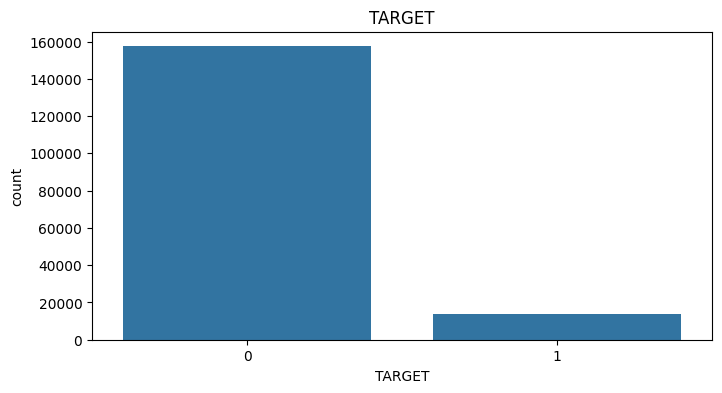

In [16]:
f,ax = plt.subplots(1,1,figsize = (8,4))
sns.countplot(x = "TARGET",data = df_)
ax.set_title("TARGET")
plt.show()

명목형 데이터 특성 개수 : 11


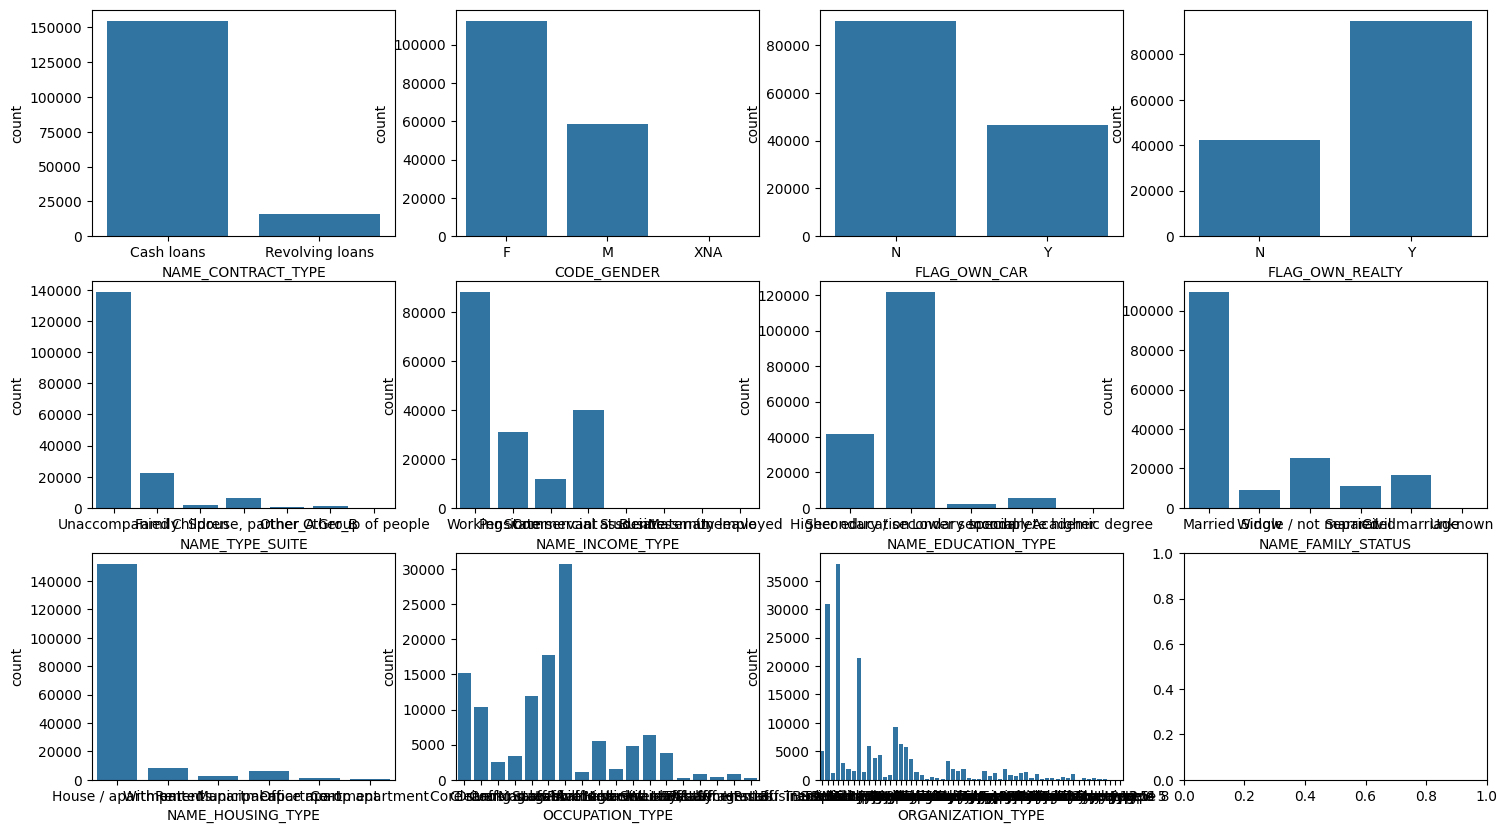

In [69]:
strarray = df_.select_dtypes("object").columns
print("명목형 데이터 특성 개수 : {}".format(len(strarray)))

fig , ax = plt.subplots(3 , 4 , figsize = (18 , 10))

for i in range(11):
    row = i // 4
    col = i % 4

    sns.countplot(data = df_ , x = df_[strarray[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(strarray[i])))
plt.show()

명목형 데이터 특성 개수 : 11


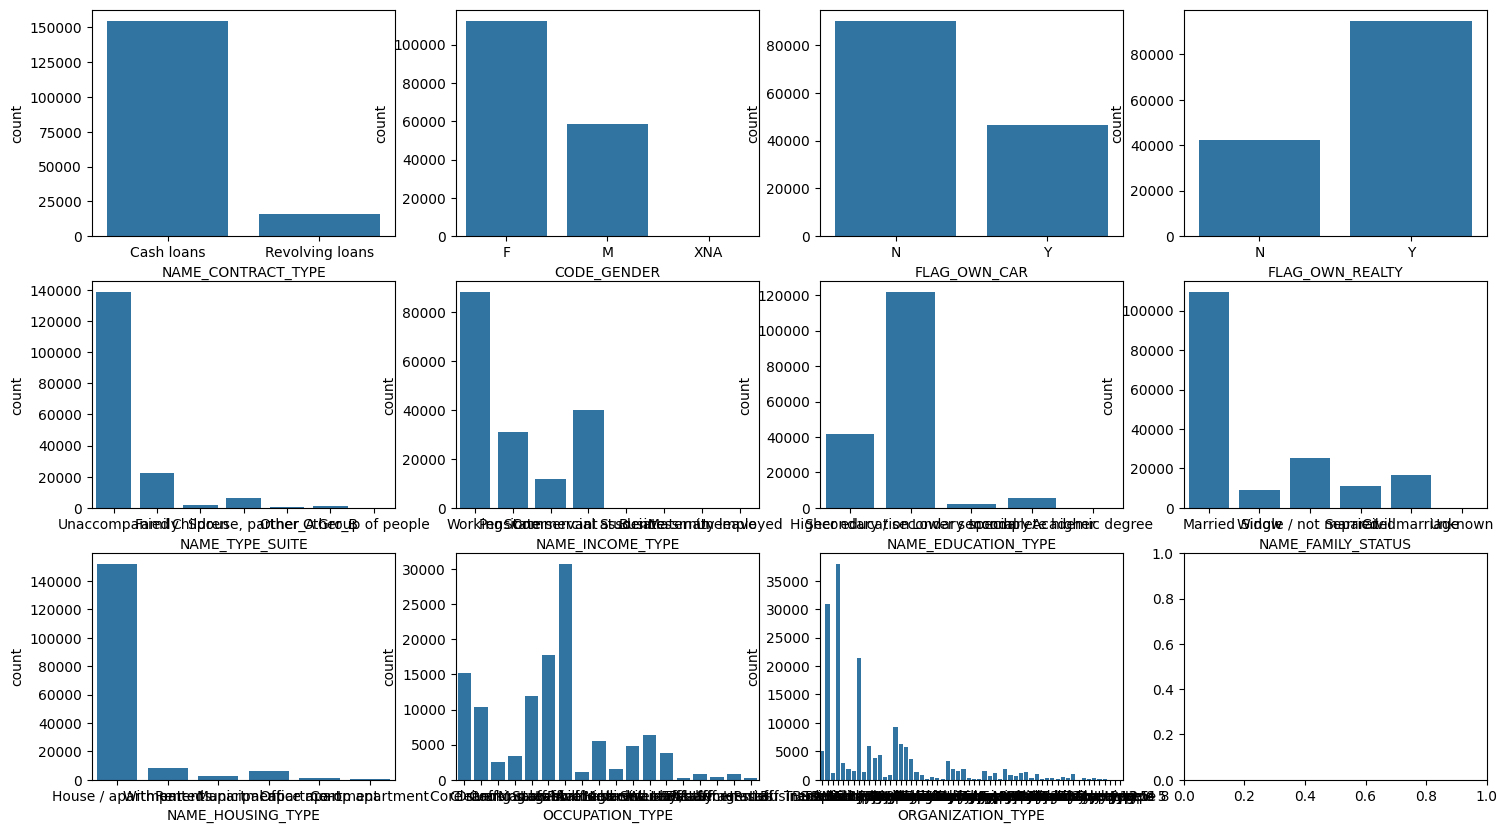

In [17]:
strarray = df_.select_dtypes("object").columns
print("명목형 데이터 특성 개수 : {}".format(len(strarray)))

fig , ax = plt.subplots(3 , 4 , figsize = (18 , 10))

for i in range(11):
    row = i // 4
    col = i % 4

    sns.countplot(data = df_ , x = df_[strarray[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(strarray[i])))
plt.show()

In [25]:
dfnum = df.copy()
strarray = df_.select_dtypes("object").columns
dfnum.drop(strarray,axis = 1,inplace=True)
dfnum.drop("SK_ID_CURR",axis = 1,inplace=True)
dfnum.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,112500.0,755190.0,36328.5,675000.0,0.010032,-9233,-878,-333.0,-522,NaN,1,1,1,1,0,0,2.0,2,2,0,1,1,0,1,1,NaN,0.372591,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,0,0,225000.0,585000.0,16893.0,585000.0,0.008019,-20148,365243,-4469.0,-3436,NaN,1,0,0,1,0,0,2.0,2,2,0,0,0,0,0,0,NaN,0.449567,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,0,0,54000.0,334152.0,18256.5,270000.0,0.004960,-18496,-523,-3640.0,-2050,NaN,1,1,1,1,1,0,2.0,2,2,0,0,0,0,0,0,NaN,0.569503,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN
3,0,0,67500.0,152820.0,8901.0,135000.0,0.005002,-24177,365243,-4950.0,-3951,NaN,1,0,0,1,1,0,1.0,3,3,0,0,0,0,0,0,NaN,0.105235,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,157500.0,271066.5,21546.0,234000.0,0.006296,-10685,-697,-5101.0,-3226,NaN,1,1,1,1,0,0,2.0,3,3,0,0,0,0,1,1,0.342344,0.202490,0.669057,0.0,0.0,0.0,0.0,-1243.0,0.0,0.0,0.0,4.0


<Axes: >

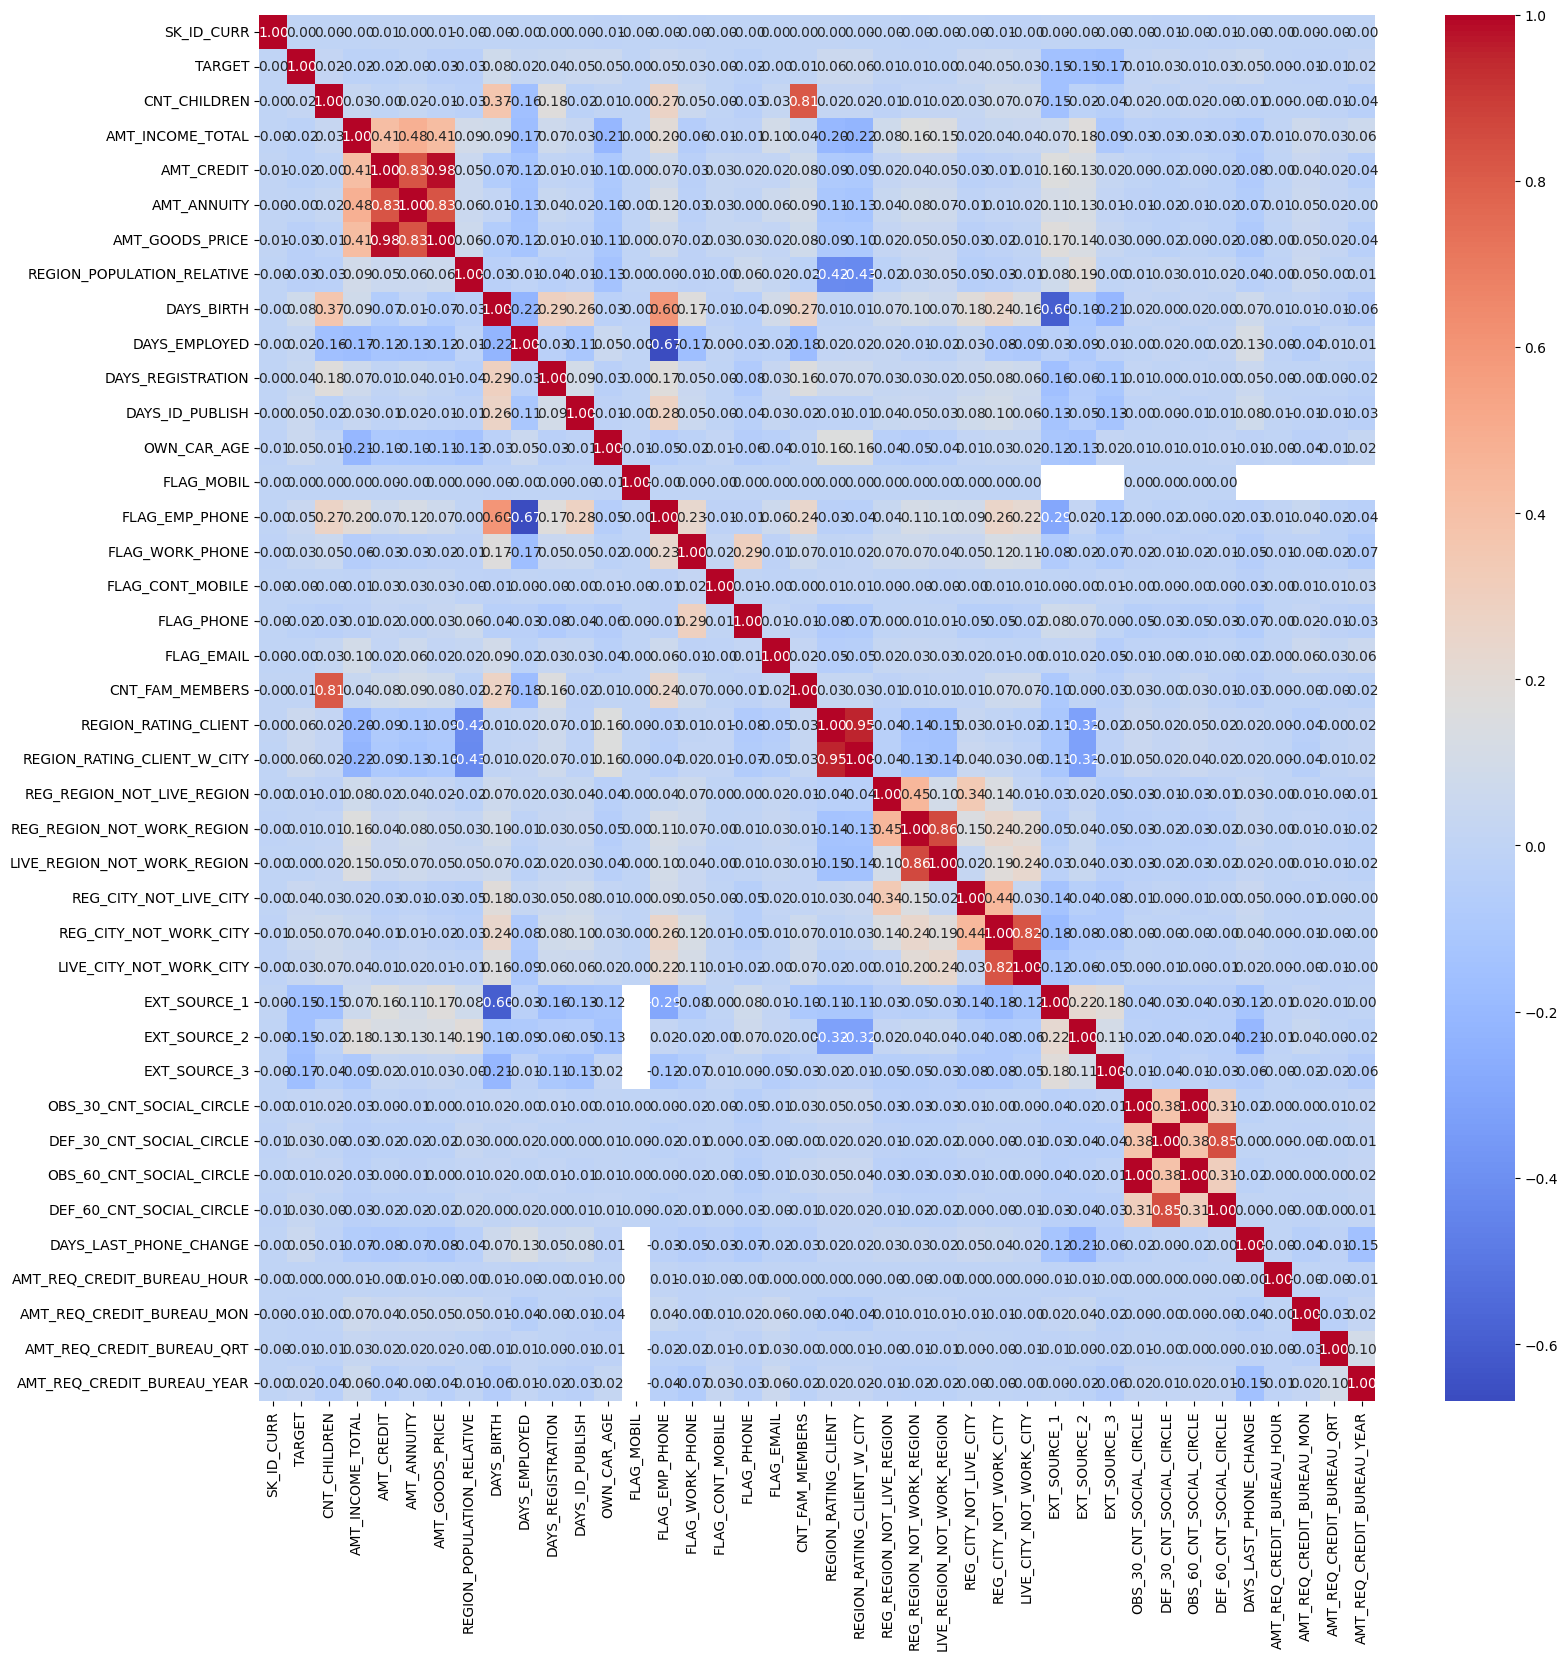

In [3]:
plt.figure(figsize=(18, 18))

sns.heatmap(data = df_.select_dtypes(['int' , 'float']).corr('spearman') ,
            annot = True ,
            fmt = '.2f' ,
            
            cmap = 'coolwarm')

In [4]:
strarray = df_.select_dtypes("object").columns
len(strarray)

11

In [3]:

df_["credit_goods_price_ratio"] = df_["AMT_CREDIT"] / df_["AMT_GOODS_PRICE"]
df_["credit_downpayment"] = df_["AMT_GOODS_PRICE"] - df_["AMT_CREDIT"]
df_["AGE_INT"] = (df_["DAYS_BIRTH"] / -365).astype(int)

In [4]:

test["credit_goods_price_ratio"] = test["AMT_CREDIT"] / test["AMT_GOODS_PRICE"]
test["credit_downpayment"] = test["AMT_GOODS_PRICE"] - test["AMT_CREDIT"]
test["AGE_INT"] = (test["DAYS_BIRTH"] / -365).astype(int)

In [5]:
# 파생변수 생성
df_["AMT_Percentage"] = df_["AMT_ANNUITY"] +df_["AMT_GOODS_PRICE"]/ df_["AMT_CREDIT"]
test["AMT_Percentage"] = test["AMT_ANNUITY"] +test["AMT_GOODS_PRICE"]/ test["AMT_CREDIT"]



In [6]:
df_['INCOME_TOTAL_CREDIT'] = df_['AMT_INCOME_TOTAL'] / df_['AMT_CREDIT']
    
df_['DAYS_BIRTH_365_OWN_CAR_AGE'] = (df_['DAYS_BIRTH'] / 365) - df_['OWN_CAR_AGE']

df_['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

In [7]:

test['INCOME_TOTAL_CREDIT'] = test['AMT_INCOME_TOTAL'] / test['AMT_CREDIT']
    
test['DAYS_BIRTH_365_OWN_CAR_AGE'] = (test['DAYS_BIRTH'] / 365) - test['OWN_CAR_AGE']

test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

In [5]:
null_counts = df_.isnull().sum()

null_counts = null_counts[null_counts > 0]
print(null_counts)

FLAG_OWN_CAR                   34241
OWN_CAR_AGE                   112992
OCCUPATION_TYPE                53745
CNT_FAM_MEMBERS                    2
EXT_SOURCE_1                  118928
EXT_SOURCE_2                     369
EXT_SOURCE_3                   54586
OBS_30_CNT_SOCIAL_CIRCLE         560
DEF_30_CNT_SOCIAL_CIRCLE         560
DAYS_LAST_PHONE_CHANGE             1
AMT_REQ_CREDIT_BUREAU_MON      23116
AMT_REQ_CREDIT_BUREAU_QRT      23116
AMT_REQ_CREDIT_BUREAU_YEAR     23116
AMT_Percentage                   169
dtype: int64


In [8]:
test['DAYS_BIRTH'] = test['DAYS_BIRTH']//-360
# # 年齢を5歳ごとにラベリング（20から71までの範囲）
bins = range(20, 76, 5)  # 20から75まで5刻みのビンを作成
labels = list(range(1, len(bins)))  # 各ビンに対する数値ラベルを作成
test['age_group'] = pd.cut(test['DAYS_BIRTH'], bins=bins, labels=labels, right=False)

test['EXT_23_mean'] = (test['EXT_SOURCE_2'] + test['EXT_SOURCE_3']) / 2
test['EXT_12_mean'] = (test['EXT_SOURCE_1'] + test['EXT_SOURCE_2']) / 2
test['EXT_13_mean'] = (test['EXT_SOURCE_1'] + test['EXT_SOURCE_3']) / 2
test['EXT_123_mean'] = (test['EXT_SOURCE_1'] + test['EXT_SOURCE_2'] + test['EXT_SOURCE_3']) / 3

# 勤続日数/年齢日数
test['DAYS_EMPLOYED_PERC'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']
# # 総収入/借入額
test['INCOME_CREDIT_PERC'] = test['AMT_INCOME_TOTAL'] / test['AMT_CREDIT']
# # 総収入/家族人数
test['INCOME_PER_PERSON'] = test['AMT_INCOME_TOTAL'] / test['CNT_FAM_MEMBERS']
# # 月々の返済額/総収入
test['ANNUITY_INCOME_PERC'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
# # 月々の返済額/借入額
test['PAYMENT_RATE'] = test['AMT_ANNUITY'] / test['AMT_CREDIT']

In [9]:
# 特徴量作成
df_['DAYS_BIRTH'] = df_['DAYS_BIRTH']//-360
# # 年齢を5歳ごとにラベリング（20から71までの範囲）
bins = range(20, 76, 5)  # 20から75まで5刻みのビンを作成
labels = list(range(1, len(bins)))  # 各ビンに対する数値ラベルを作成
df_['age_group'] = pd.cut(df_['DAYS_BIRTH'], bins=bins, labels=labels, right=False)

df_['EXT_23_mean'] = (df_['EXT_SOURCE_2'] + df_['EXT_SOURCE_3']) / 2
df_['EXT_12_mean'] = (df_['EXT_SOURCE_1'] + df_['EXT_SOURCE_2']) / 2
df_['EXT_13_mean'] = (df_['EXT_SOURCE_1'] + df_['EXT_SOURCE_3']) / 2
df_['EXT_123_mean'] = (df_['EXT_SOURCE_1'] + df_['EXT_SOURCE_2'] + df_['EXT_SOURCE_3']) / 3

# 勤続日数/年齢日数
df_['DAYS_EMPLOYED_PERC'] = df_['DAYS_EMPLOYED'] / df_['DAYS_BIRTH']
# # 総収入/借入額
df_['INCOME_CREDIT_PERC'] = df_['AMT_INCOME_TOTAL'] / df_['AMT_CREDIT']
# # 総収入/家族人数
df_['INCOME_PER_PERSON'] = df_['AMT_INCOME_TOTAL'] / df_['CNT_FAM_MEMBERS']
# # 月々の返済額/総収入
df_['ANNUITY_INCOME_PERC'] = df_['AMT_ANNUITY'] / df_['AMT_INCOME_TOTAL']
# # 月々の返済額/借入額
df_['PAYMENT_RATE'] = df_['AMT_ANNUITY'] / df_['AMT_CREDIT']




In [10]:
dropcolumns = ["age_group",'FLAG_MOBIL','REG_REGION_NOT_LIVE_REGION','FLAG_CONT_MOBILE','FLAG_EMAIL','FLAG_EMP_PHONE','LIVE_CITY_NOT_WORK_CITY','LIVE_REGION_NOT_WORK_REGION','REG_REGION_NOT_WORK_REGION','REG_CITY_NOT_WORK_CITY','AMT_REQ_CREDIT_BUREAU_HOUR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','CNT_CHILDREN','FLAG_PHONE']
df_.drop(dropcolumns,axis = 1,inplace=True)
test.drop(dropcolumns,axis = 1,inplace=True)

df_["NAME_INCOME_TYPE"] = df_["NAME_INCOME_TYPE"].replace(['Pensioner','Commercial associate','Student',
                                                            'Businessman','Maternity leave','Unemployed'],np.nan)
df_["NAME_EDUCATION_TYPE"] = df_["NAME_EDUCATION_TYPE"].replace(['Lower secondary','Incomplete higher'] ,np.nan)
df_["NAME_HOUSING_TYPE"] = df_["NAME_HOUSING_TYPE"].replace( ['Co-op apartment','Municipal apartment'],np.nan)

test["NAME_INCOME_TYPE"] = test["NAME_INCOME_TYPE"].replace(['Pensioner','Commercial associate','Student',
                                                            'Businessman','Maternity leave','Unemployed'],np.nan)
test["NAME_EDUCATION_TYPE"] = test["NAME_EDUCATION_TYPE"].replace(['Lower secondary','Incomplete higher'] ,np.nan)
test["NAME_HOUSING_TYPE"] = test["NAME_HOUSING_TYPE"].replace( ['Co-op apartment','Municipal apartment'],np.nan)

# model

In [11]:
Ndf = df_.copy()
Ntest = test.copy()

In [16]:
Ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   171202 non-null  int64  
 1   TARGET                       171202 non-null  int64  
 2   NAME_CONTRACT_TYPE           171202 non-null  object 
 3   CODE_GENDER                  171202 non-null  object 
 4   FLAG_OWN_CAR                 136961 non-null  object 
 5   AMT_INCOME_TOTAL             171202 non-null  float64
 6   NAME_INCOME_TYPE             171202 non-null  object 
 7   NAME_EDUCATION_TYPE          171202 non-null  object 
 8   NAME_FAMILY_STATUS           171202 non-null  object 
 9   NAME_HOUSING_TYPE            171202 non-null  object 
 10  REGION_POPULATION_RELATIVE   171202 non-null  float64
 11  DAYS_BIRTH                   171202 non-null  int64  
 12  DAYS_EMPLOYED                140304 non-null  float64
 13 

In [61]:
Ntest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61500 entries, 0 to 61499
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SK_ID_CURR                   61500 non-null  int64  
 1   NAME_CONTRACT_TYPE           61500 non-null  object 
 2   CODE_GENDER                  61500 non-null  object 
 3   AMT_INCOME_TOTAL             61500 non-null  float64
 4   NAME_INCOME_TYPE             61500 non-null  object 
 5   NAME_EDUCATION_TYPE          61500 non-null  object 
 6   NAME_FAMILY_STATUS           61500 non-null  object 
 7   NAME_HOUSING_TYPE            61500 non-null  object 
 8   REGION_POPULATION_RELATIVE   61500 non-null  float64
 9   DAYS_BIRTH                   61500 non-null  int64  
 10  DAYS_EMPLOYED                61500 non-null  int64  
 11  DAYS_REGISTRATION            61500 non-null  float64
 12  DAYS_ID_PUBLISH              61500 non-null  int64  
 13  FLAG_MOBIL      

In [10]:
df_.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60

<Axes: >

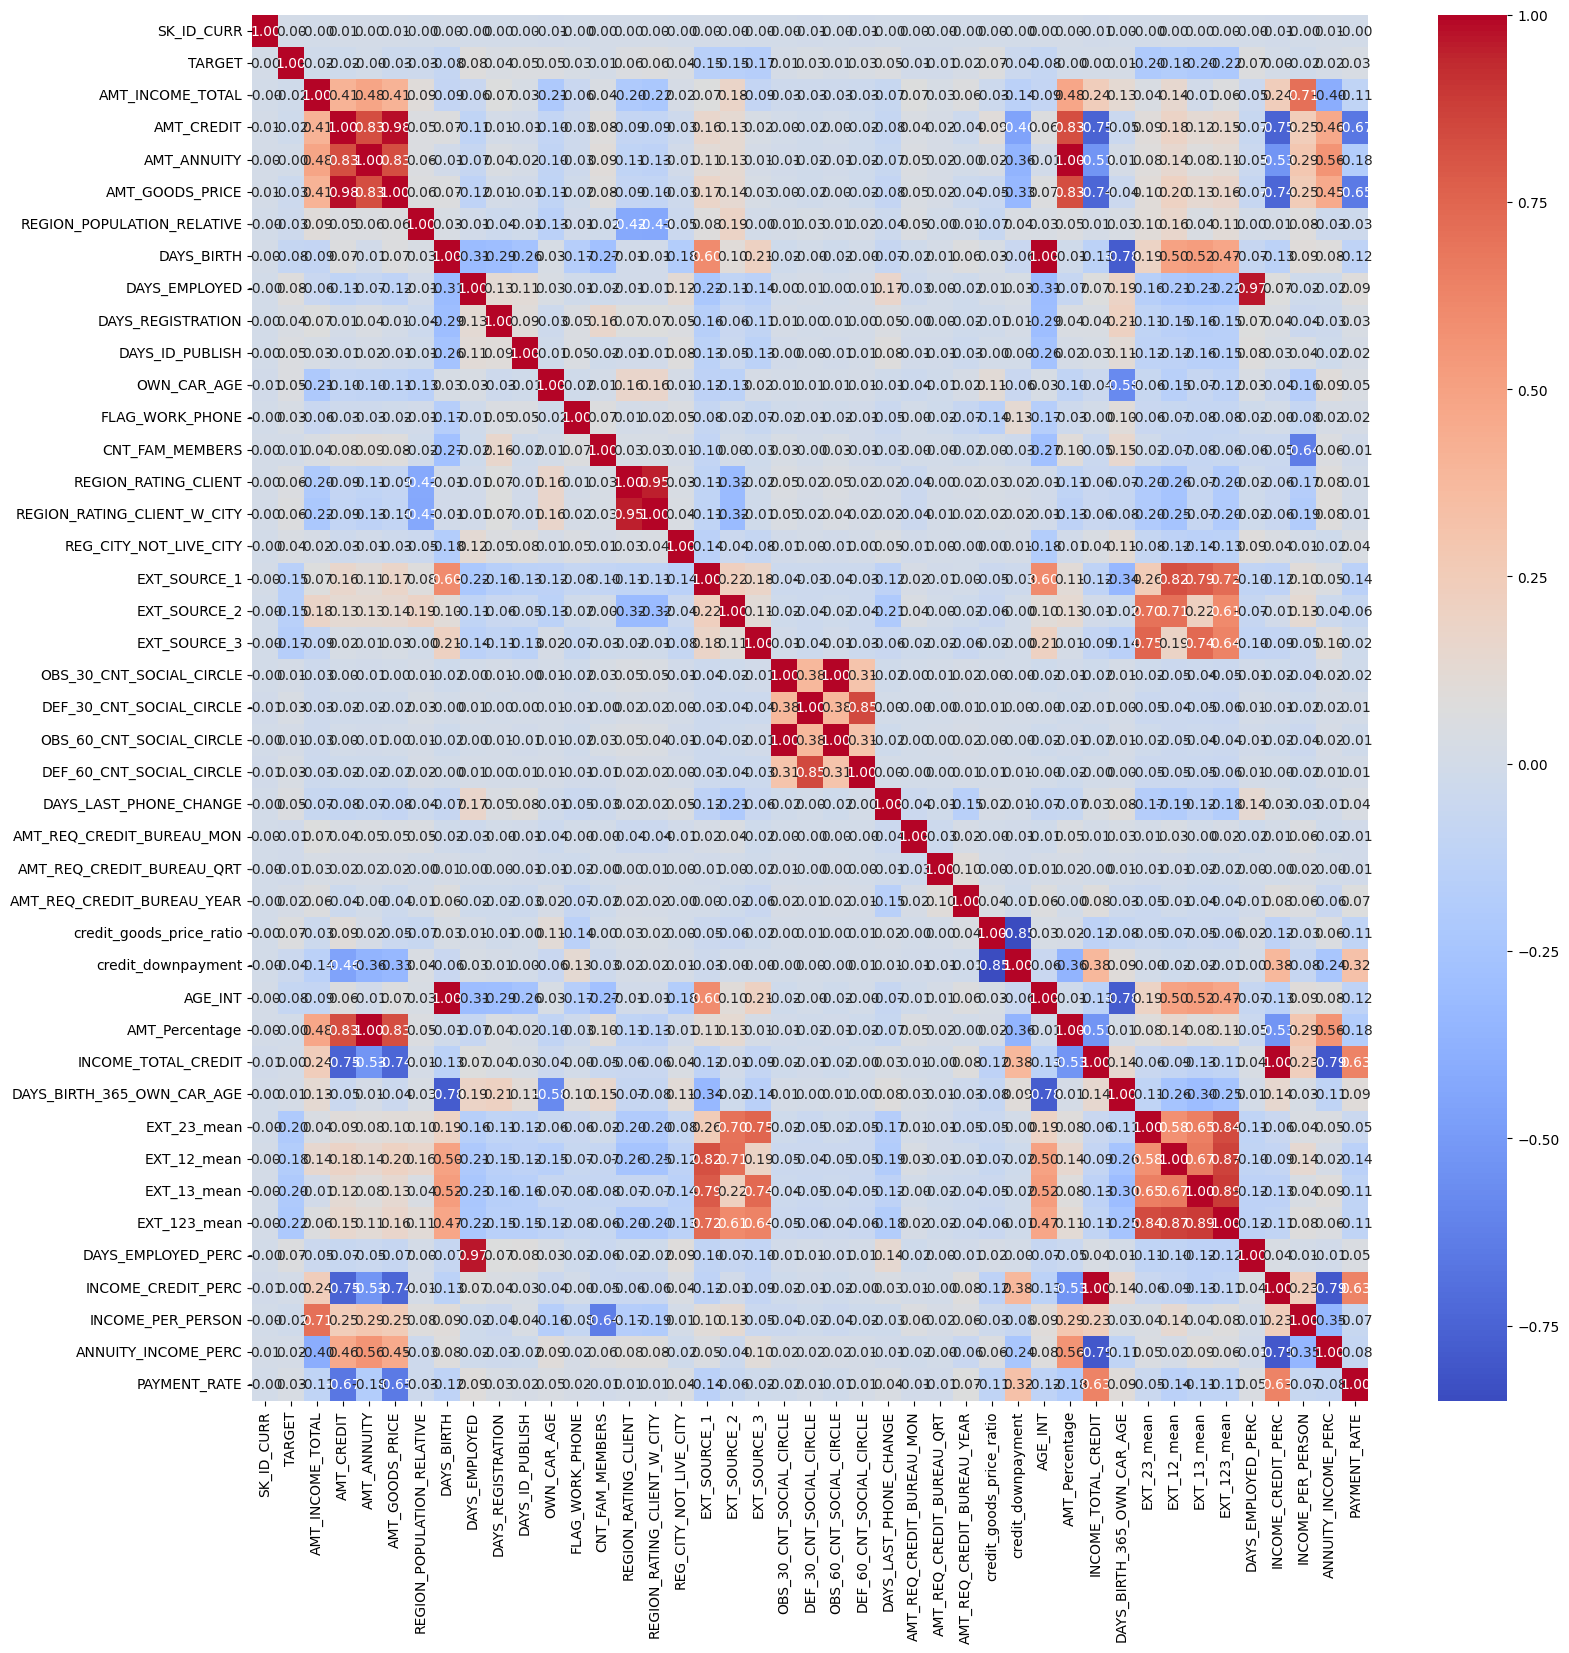

In [12]:

plt.figure(figsize=(18, 18))

sns.heatmap(data = Ndf.select_dtypes(['int' , 'float']).corr('spearman'),
            annot = True ,
            fmt = '.2f' ,
            
            cmap = 'coolwarm')

In [10]:
Ntest.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'AMT_Percentage'],
      dtype='object')

In [51]:
Ntest.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_WORK_PHONE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'AMT_Percentage'],
      dtype='object')

In [19]:
Nstrarray = Ndf.select_dtypes("object").columns
len(Nstrarray)

9

명목형 데이터 특성 개수 : 9


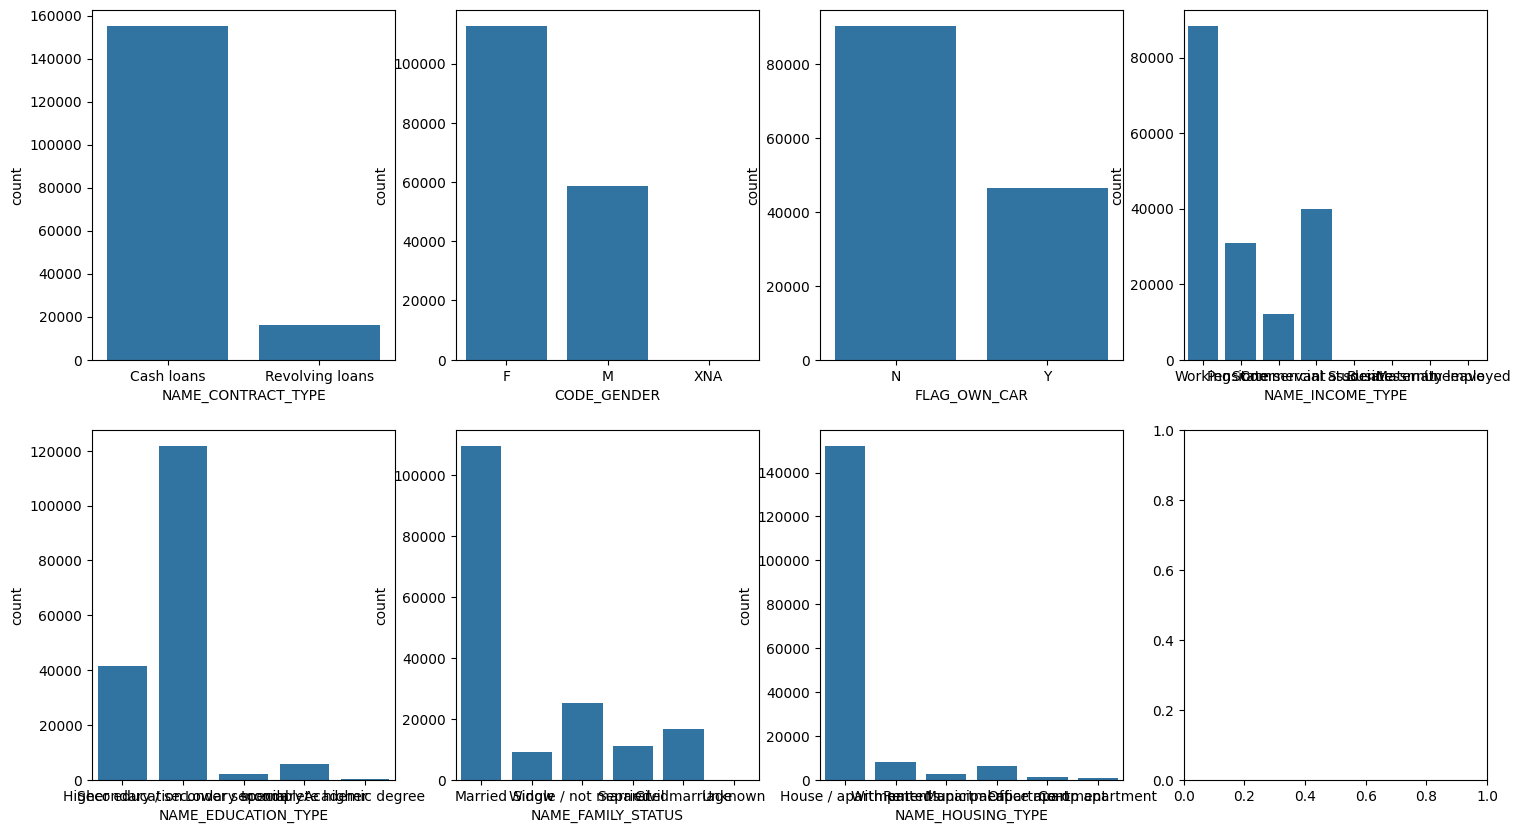

In [7]:
Nstrarray = Ndf.select_dtypes("object").columns
print("명목형 데이터 특성 개수 : {}".format(len(Nstrarray)))

fig , ax = plt.subplots(2 , 4 , figsize = (18 , 10))

for i in range(7):
    row = i // 4
    col = i % 4

    sns.countplot(data = Ndf, x = Ndf[Nstrarray[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(Nstrarray[i])))
plt.show()

In [50]:
list(Ntest.select_dtypes("int").columns)
list(Ntest.select_dtypes("float").columns)

['AMT_INCOME_TOTAL',
 'REGION_POPULATION_RELATIVE',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_Percentage']

명목형 데이터 특성 개수 : 9


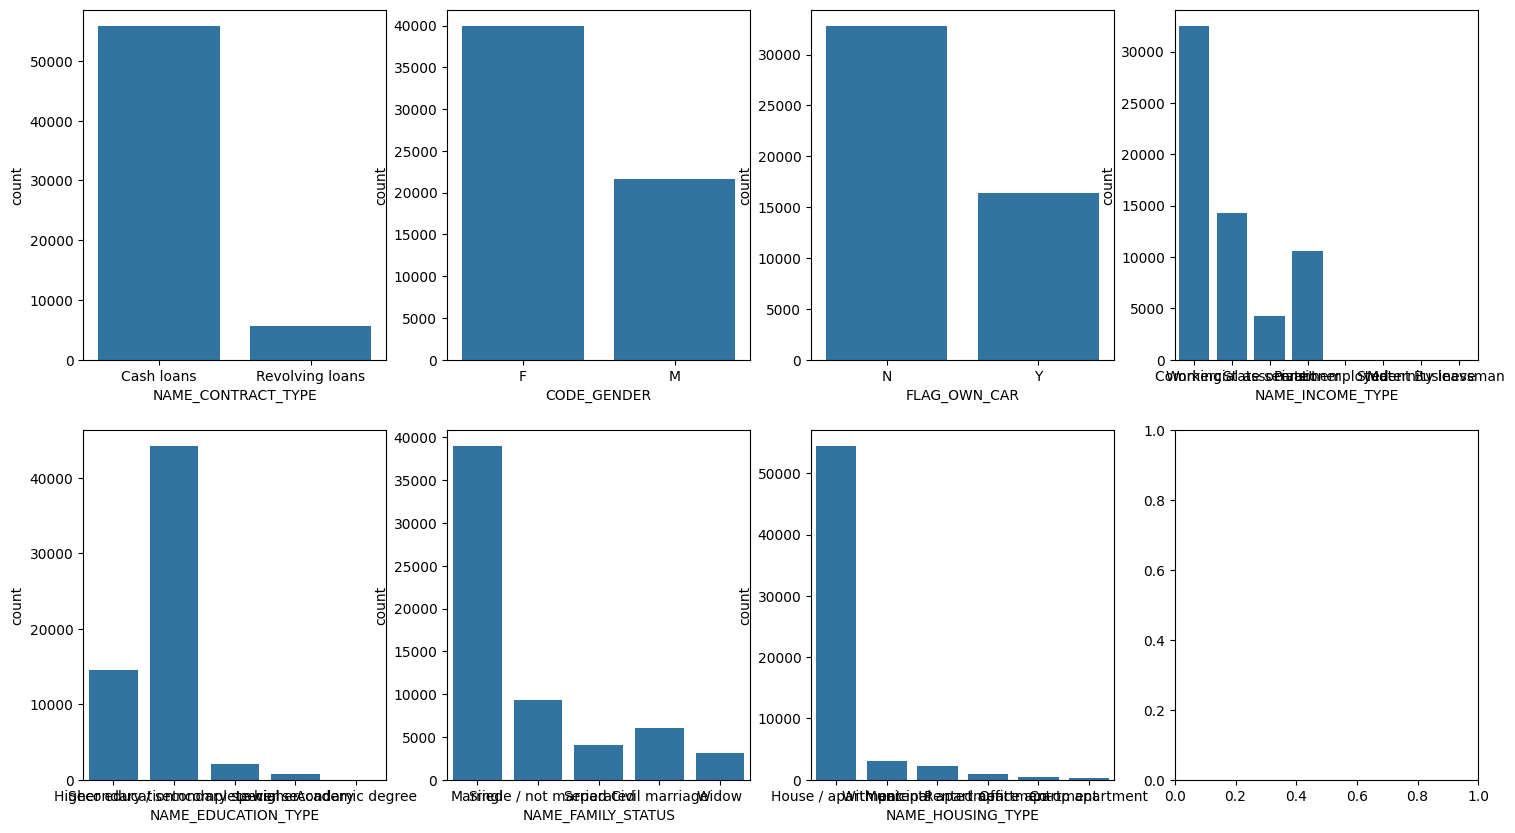

In [35]:
Nstrarray = Ntest.select_dtypes("object").columns
print("명목형 데이터 특성 개수 : {}".format(len(Nstrarray)))

fig , ax = plt.subplots(2 , 4 , figsize = (18 , 10))

for i in range(7):
    row = i // 4
    col = i % 4

    sns.countplot(data = Ntest, x = Ntest[Nstrarray[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(Nstrarray[i])))
plt.show()

In [13]:
I =list(Ntest.select_dtypes("int").columns)
F = list(Ntest.select_dtypes("float").columns)
numcolumns = I+F


In [14]:

removecolumns = ["SK_ID_CURR","REGION_POPULATION_RELATIVE",'FLAG_WORK_PHONE',
                 'REGION_RATING_CLIENT_W_CITY','REG_CITY_NOT_LIVE_CITY','CNT_FAM_MEMBERS']
for i in removecolumns:
    numcolumns.remove(i)
print(len(numcolumns))

36


In [62]:
for i in removecolumns:
    print(Ndf[i].unique())

[     0      1      2 ... 171199 171200 171201]
[0.010032 0.008019 0.00496  0.005002 0.006296 0.018209 0.011657 0.006671
 0.010643 0.020713 0.022625 0.018029 0.072508 0.01452  0.04622  0.003818
 0.003813 0.031329 0.025164 0.002134 0.035792 0.00712  0.01885  0.002042
 0.02461  0.007114 0.026392 0.004849 0.008866 0.030755 0.008575 0.003069
 0.018634 0.010147 0.020246 0.00702  0.019101 0.016612 0.010966 0.019689
 0.018801 0.028663 0.005144 0.006305 0.007305 0.010006 0.006008 0.015221
 0.009334 0.009175 0.0228   0.009549 0.002506 0.011703 0.00733  0.008625
 0.008474 0.00963  0.006852 0.008068 0.005313 0.032561 0.003122 0.006629
 0.006233 0.010556 0.006207 0.009657 0.00823  0.014464 0.0105   0.005084
 0.007274 0.010276 0.001417 0.001276 0.003541 0.001333 0.000938 0.000533
 0.00029 ]
[1 0]
[2 3 1]
[0 1]
[ 2.  1.  3.  4.  5.  6.  7.  8. 11. nan 12.  9. 14. 10. 15. 16.]


int or float columns : 36


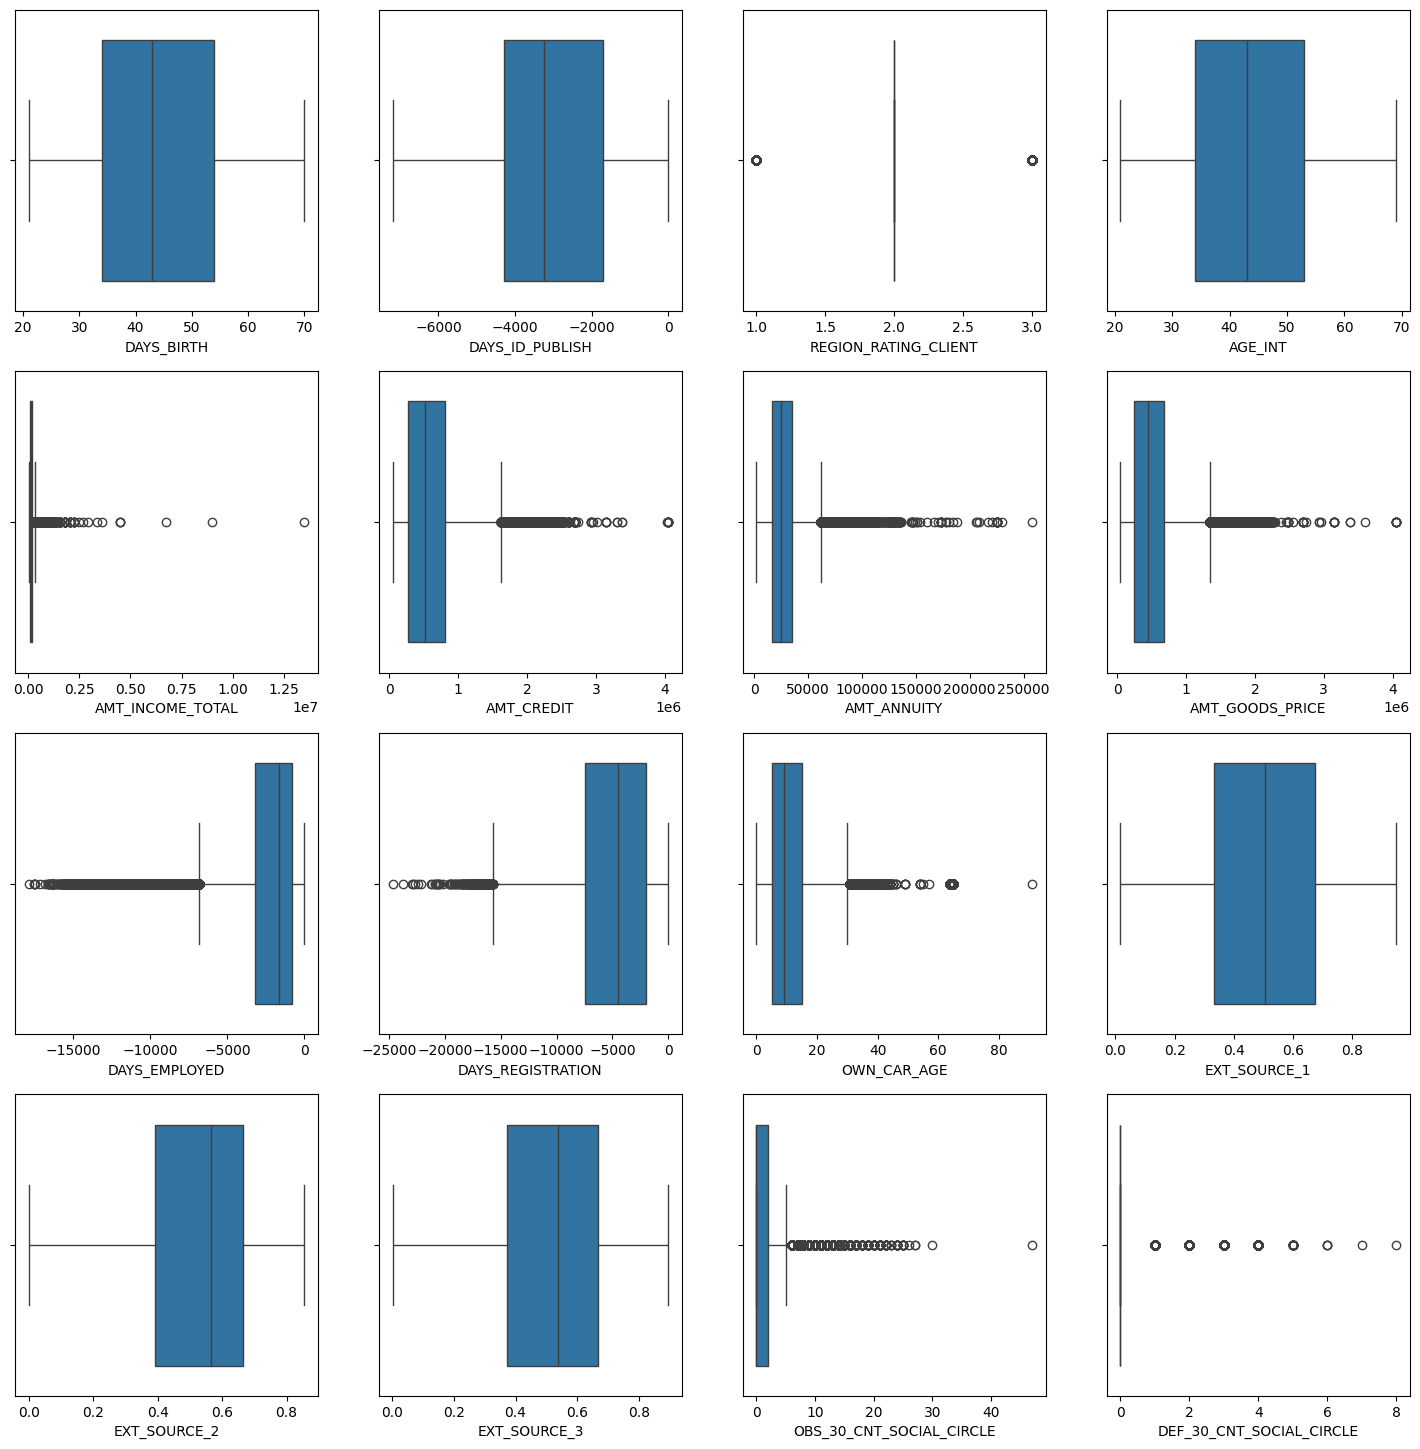

In [15]:
print("int or float columns : {}".format(len(numcolumns)))

fig , ax = plt.subplots(4 , 4 , figsize = (18 , 18))

for i in range(16):
    row = i // 4
    col = i % 4

    sns.boxplot(data = Ndf, x = Ndf[numcolumns[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(numcolumns[i])))
plt.show()

int or float columns : 16


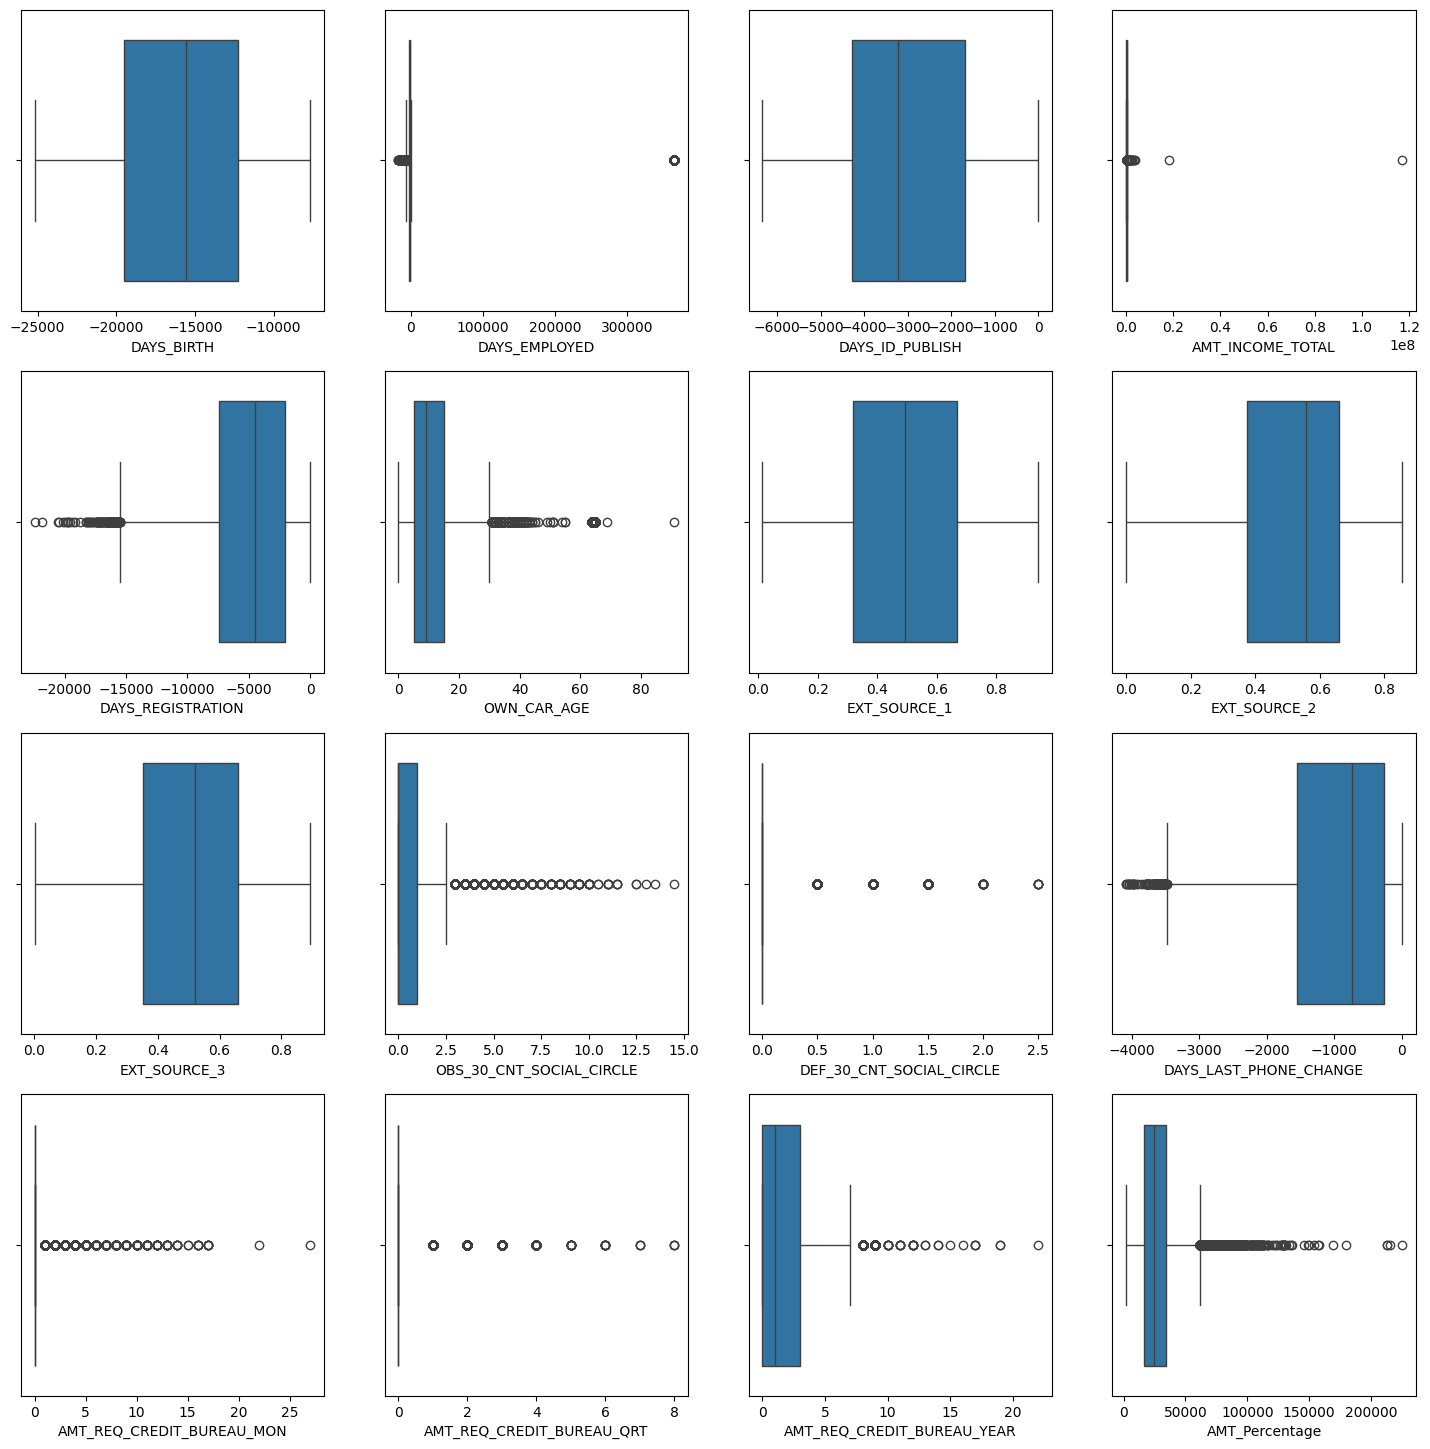

In [31]:
print("int or float columns : {}".format(len(numcolumns)))

fig , ax = plt.subplots(4 , 4 , figsize = (18 , 18))

for i in range(16):
    row = i // 4
    col = i % 4

    sns.boxplot(data = Ntest, x = Ntest[numcolumns[i]] , ax = ax[row][col])
    ax[row][col].set_title("".format(str(numcolumns[i])))
plt.show()

In [16]:
numcolumns

['DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'REGION_RATING_CLIENT',
 'AGE_INT',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'credit_goods_price_ratio',
 'credit_downpayment',
 'AMT_Percentage',
 'INCOME_TOTAL_CREDIT',
 'DAYS_BIRTH_365_OWN_CAR_AGE',
 'EXT_23_mean',
 'EXT_12_mean',
 'EXT_13_mean',
 'EXT_123_mean',
 'DAYS_EMPLOYED_PERC',
 'INCOME_CREDIT_PERC',
 'INCOME_PER_PERSON',
 'ANNUITY_INCOME_PERC',
 'PAYMENT_RATE']

In [17]:
# tukey

def tukey(data , c):
    q1 = np.percentile(data[c] , 25)
    q3 = np.percentile(data[c] , 75)

    IQR = q3 - q1

    upper_fence = q3 + 1.5 * IQR
    lower_fence = q1 - 1.5 * IQR

    return data[(data[c] < lower_fence) | (data[c] > upper_fence)]

In [18]:
outlierarray =['DAYS_EMPLOYED',
 'AMT_INCOME_TOTAL',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AMT_Percentage']
 

In [21]:
# 비율 확인

length = Ndf.shape[0]
t_length = Ntest.shape[0]
for i in outlierarray:
    print("{0} Outlier Percentage :{1}%".format(i,round((tukey(Ndf , i).shape[0]) / length * 100 , 10)))
    print("Test {0} Outlier Percentage :{1}%".format(i,round((tukey(Ntest ,i).shape[0]) / t_length * 100,10)))


DAYS_EMPLOYED Outlier Percentage :0.0%
Test DAYS_EMPLOYED Outlier Percentage :0.0%
AMT_INCOME_TOTAL Outlier Percentage :4.5466758566%
Test AMT_INCOME_TOTAL Outlier Percentage :4.3756097561%
DAYS_REGISTRATION Outlier Percentage :0.2032686534%
Test DAYS_REGISTRATION Outlier Percentage :0.2325203252%
OWN_CAR_AGE Outlier Percentage :0.0%
Test OWN_CAR_AGE Outlier Percentage :0.0%
OBS_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
Test OBS_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
DEF_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
Test DEF_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
OBS_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
Test OBS_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
DEF_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
Test DEF_30_CNT_SOCIAL_CIRCLE Outlier Percentage :0.0%
DAYS_LAST_PHONE_CHANGE Outlier Percentage :0.0%
Test DAYS_LAST_PHONE_CHANGE Outlier Percentage :0.1756097561%
AMT_REQ_CREDIT_BUREAU_MON Outlier Percentage :0.0%
Test AMT_REQ_CREDIT_BUREAU_MON Outlier Pe

In [20]:
# outlier
Ntest.loc[Ntest["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = 60
Ntest['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
Ndf.loc[Ndf["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = 60
Ndf['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)



In [13]:
print(Ndf["NAME_EDUCATION_TYPE"].unique())
print(Ntest["NAME_EDUCATION_TYPE"].unique())

['Higher education' 'Secondary / secondary special' 'Lower secondary'
 'Incomplete higher' 'Academic degree']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']


In [14]:
print(Ndf["NAME_INCOME_TYPE"].unique())
print(Ntest["NAME_INCOME_TYPE"].unique())

['Working' 'Pensioner' 'State servant' 'Commercial associate' 'Student'
 'Businessman' 'Maternity leave' 'Unemployed']
['Working' 'Commercial associate' 'State servant' 'Pensioner' 'Unemployed'
 'Student' 'Maternity leave' 'Businessman']


In [92]:

print(Ndf["NAME_HOUSING_TYPE"].unique())
print(Ntest["NAME_HOUSING_TYPE"].unique())

['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
['House / apartment' 'With parents' 'Municipal apartment'
 'Rented apartment' 'Office apartment' 'Co-op apartment']


In [93]:

print(Ndf["NAME_HOUSING_TYPE"].unique())
print(Ntest["NAME_HOUSING_TYPE"].unique())

['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
['House / apartment' 'With parents' 'Municipal apartment'
 'Rented apartment' 'Office apartment' 'Co-op apartment']


In [24]:
# CODE_GENDER
mode = Ndf["CODE_GENDER"].mode().iloc[0]
Ndf["CODE_GENDER"] = Ndf["CODE_GENDER"].replace('XNA', mode)

In [66]:
Ndf[Ndf["NAME_FAMILY_STATUS"] == "Unknown"]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_INCOME_TYPE,...,AMT_Percentage,EXT_23_mean,EXT_12_mean,EXT_13_mean,EXT_123_mean,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
47453,47453,0,Revolving loans,F,N,202500.0,585000.0,29250.0,NaN,NaN,...,NaN,0.65791,NaN,NaN,NaN,-6.628571,0.346154,NaN,0.144444,0.05
74592,74592,0,Revolving loans,M,N,450000.0,675000.0,33750.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-34.147059,0.666667,NaN,0.075000,0.05


In [22]:
# NAME_FAMILY_STATUS
print(Ndf["NAME_FAMILY_STATUS"].unique())
print(Ntest["NAME_FAMILY_STATUS"].unique())
mode = Ndf["NAME_FAMILY_STATUS"].mode().iloc[0]
Ndf["NAME_FAMILY_STATUS"] = Ndf["NAME_FAMILY_STATUS"].replace('Unknown', mode)

['Married' 'Widow' 'Single / not married' 'Separated' 'Civil marriage'
 'Unknown']
['Married' 'Single / not married' 'Separated' 'Civil marriage' 'Widow']


In [23]:
# ORGANIZATION_TYPE
mode = Ndf["ORGANIZATION_TYPE"].mode().iloc[0]
Ndf["ORGANIZATION_TYPE"] = Ndf["ORGANIZATION_TYPE"].replace('XNA', mode)

Tmode = Ntest["ORGANIZATION_TYPE"].mode().iloc[0]
Ntest["ORGANIZATION_TYPE"] = Ntest["ORGANIZATION_TYPE"].replace('XNA', Tmode)

In [25]:
#2
E = LabelEncoder()
Larray = ["NAME_CONTRACT_TYPE","CODE_GENDER","FLAG_OWN_CAR"]
for i in range(3):
    Labeled = E.fit_transform(Ndf[Larray[i]])
    Ndf[Larray[i]] = Labeled
    testLabeled = E.fit_transform(Ntest[Larray[i]])
    Ntest[Larray[i]] = testLabeled
    

In [26]:
# some
ColumnsOneHot = ["NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE"]
encoder = OneHotEncoder(sparse_output = False)

Ndf_encoded = pd.get_dummies(Ndf[ColumnsOneHot])

Ndf.drop(columns=ColumnsOneHot, inplace=True)
Ndf = pd.concat([Ndf, Ndf_encoded], axis=1)

Ntest_encoded = pd.get_dummies(Ntest[ColumnsOneHot])

Ntest.drop(columns=ColumnsOneHot, inplace=True)
Ntest = pd.concat([Ntest, Ntest_encoded], axis=1)

In [24]:
Ndf["ORGANIZATION_TYPE"]

0                         School
1         Business Entity Type 3
2                         Postal
3         Business Entity Type 3
4         Business Entity Type 3
                   ...          
171197               Agriculture
171198          Industry: type 3
171199                    School
171200    Business Entity Type 3
171201              Kindergarten
Name: ORGANIZATION_TYPE, Length: 171202, dtype: object

In [27]:
# too many

encoder = TargetEncoder()
Ndf["ORGANIZATION_TYPE"] = encoder.fit_transform(Ndf["ORGANIZATION_TYPE"] ,Ndf["TARGET"] )
Ntest["ORGANIZATION_TYPE"] = encoder.transform(Ntest["ORGANIZATION_TYPE"])


Ndf["OCCUPATION_TYPE"] = encoder.fit_transform(Ndf["OCCUPATION_TYPE"] ,Ndf["TARGET"] )
Ntest["OCCUPATION_TYPE"] = encoder.transform(Ntest["OCCUPATION_TYPE"])

In [19]:
Ndf.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
0,0,0,0,0,112500.0,0.010032,-9233,-878,-333.0,-522,...,True,False,False,False,False,True,False,False,False,False
1,1,0,0,0,225000.0,0.008019,-20148,365243,-4469.0,-3436,...,True,False,False,False,False,True,False,False,False,False
2,2,0,0,0,54000.0,0.004960,-18496,-523,-3640.0,-2050,...,True,False,False,False,False,True,False,False,False,False
3,3,0,0,0,67500.0,0.005002,-24177,365243,-4950.0,-3951,...,False,False,False,True,False,True,False,False,False,False
4,4,1,0,1,157500.0,0.006296,-10685,-697,-5101.0,-3226,...,True,False,False,False,False,False,False,False,False,True


In [29]:
columns = list(Ndf.columns)
columns.remove('TARGET')
columns.remove('SK_ID_CURR')

In [21]:
Ntest.columns
columns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'AMT_INCOME_TOTAL',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'NAME_INCOME_TYPE_Businessman',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Maternity leave',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Student',
 'NAME_INCOME_TYPE_Unemployed',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Academic degree',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_EDUCATION_TYPE_Secondary / secondary

In [16]:
Ndf.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_Percentage,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents
0,0,0,0,0,N,112500.0,0.010032,-9233,-878.0,-333.0,-522,NaN,1,Core staff,2.0,2,0,0.059707,NaN,0.372591,NaN,0.0,0.0,-292.0,NaN,NaN,NaN,36329.393815,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False
1,1,0,0,0,N,225000.0,0.008019,-20148,NaN,-4469.0,-3436,NaN,0,NaN,2.0,2,0,0.054243,NaN,0.449567,0.553165,0.0,0.0,-617.0,0.0,0.0,1.0,16894.000000,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False
2,2,0,0,0,N,54000.0,0.004960,-18496,-523.0,-3640.0,-2050,NaN,1,Core staff,2.0,2,0,0.082700,NaN,0.569503,NaN,2.0,0.0,-542.0,NaN,NaN,NaN,18257.308016,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False
3,3,0,0,0,N,67500.0,0.005002,-24177,NaN,-4950.0,-3951,NaN,0,NaN,1.0,3,0,0.054243,NaN,0.105235,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,8901.883392,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False
4,4,1,0,1,N,157500.0,0.006296,-10685,-697.0,-5101.0,-3226,NaN,1,Drivers,2.0,3,0,0.093614,0.342344,0.202490,0.669057,0.0,0.0,-1243.0,0.0,0.0,4.0,21546.863257,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True


In [31]:

from sklearn.preprocessing import StandardScaler
X = Ndf[columns]
Y = Ndf["TARGET"]
scaler = StandardScaler()
Test_X = Ntest[columns]

# Oversampling
smote = SMOTE(random_state=42)
X_res_smote, y_res_smote = smote.fit_resample(X, Y)
df_res_smote = pd.DataFrame(X_res_smote, columns= columns)
df_res_smote['price_range'] = y_res_smote

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [33]:
# LGBMClassifier
lgb = LGBMClassifier(learning_rate = 0.1, max_depth = 3, num_leaves = 10)
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_test)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, lgb_valid_pred)}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11021, number of negative: 125940
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6775
[LightGBM] [Info] Number of data points in the train set: 136961, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080468 -> initscore=-2.436003
[LightGBM] [Info] Start training from score -2.436003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [34]:

xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)

xgb_train_pred = xgb.predict_proba(X_train)[:, 1]
xgb_valid_pred = xgb.predict_proba(X_test)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, xgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, xgb_valid_pred)}")

Train Score: 0.8985992518909106
Valid Score: 0.7523406028070717


In [36]:
# パラメータ探索範囲の定義
param_dist = {
    'num_leaves': randint(6, 50),  # 6から50の間の整数
    'learning_rate': uniform(0.01, 0.3),  # 0.01から0.3の間の一様分布
    'max_depth': randint(3, 15),  # 3から15の間の整数
    'min_child_samples': randint(20, 50),  # 20から50の間の整数
    'feature_fraction': uniform(0.5, 0.5),  # 0.5から1.0の間の一様分布
    'bagging_fraction': uniform(0.5, 0.5)  # 0.5から1.0の間の一様分布
}

# LightGBM分類器の定義
lgbm = LGBMClassifier(objective='binary', metric='auc', random_state=42)

# ランダムサーチの設定
n_iter_search = 20  # 試行回数を指定

random_search = RandomizedSearchCV(
    lgbm, param_distributions=param_dist, n_iter=n_iter_search, scoring='roc_auc', cv=5, random_state=42
)

# ランダムサーチの実行
random_search.fit(X_train, y_train)

print("Best Parameters found: ", random_search.best_params_)
print("Best ROC AUC Score found: {:.4f}".format(random_search.best_score_))

[LightGBM] [Warning] feature_fraction is set=0.9753571532049581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9753571532049581
[LightGBM] [Warning] bagging_fraction is set=0.6872700594236812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6872700594236812
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9753571532049581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9753571532049581
[LightGBM] [Warning] bagging_fraction is set=0.6872700594236812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6872700594236812
[LightGBM] [Info] Number of positive: 8816, number of negative: 100752
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6764
[LightGBM] [Info] Number of data points in the trai

In [35]:
train_pred = (lgb_train_pred + xgb_train_pred)/2
valid_pred = (lgb_valid_pred + xgb_valid_pred)/2

print(f"Train Score: {roc_auc_score(y_train, train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, valid_pred)}")

Train Score: 0.8668911633711477
Valid Score: 0.7636549069231714


In [38]:


# データの準備（Xは特徴量、yは目的変数とする）
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBMのモデルを定義
model = LGBMClassifier()

# 探索するハイパーパラメータの範囲を指定
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 500],
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'max_depth': [-1, 10, 20, 30],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# GridSearchCVを用いて最適なハイパーパラメータを探索
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 最適なハイパーパラメータとそのスコアを表示
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))

# テストデータでの性能評価（任意）
# test_accuracy = best_model.(X_test, y_test)
# print("Test set accuracy of best model: {:.2f}".format(test_accuracy))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7347, number of negative: 83960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6752
[LightGBM] [Info] Number of data points in the train set: 91307, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080465 -> initscore=-2.436048
[LightGBM] [Info] Start training from score -2.436048
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7347, number of negative: 83960
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6757
[LightGBM] [Info] Number of data points in the train set: 91307, number of used f

KeyboardInterrupt: 

In [37]:
# LGBMClassifier
lgb = LGBMClassifier(learning_rate = 0.09, max_depth = 7, num_leaves = 12,n_estimators = 130)
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_test)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_test, lgb_valid_pred)}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11021, number of negative: 125940
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6775
[LightGBM] [Info] Number of data points in the train set: 136961, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080468 -> initscore=-2.436003
[LightGBM] [Info] Start training from score -2.436003
Train Score: 0.7857143242079161
Valid Score: 0.761768823238083


Feature: NAME_CONTRACT_TYPE, Importance: 12
Feature: CODE_GENDER, Importance: 23
Feature: FLAG_OWN_CAR, Importance: 2
Feature: AMT_INCOME_TOTAL, Importance: 22
Feature: AMT_CREDIT, Importance: 20
Feature: AMT_ANNUITY, Importance: 30
Feature: AMT_GOODS_PRICE, Importance: 43
Feature: REGION_POPULATION_RELATIVE, Importance: 20
Feature: DAYS_BIRTH, Importance: 26
Feature: DAYS_EMPLOYED, Importance: 44
Feature: DAYS_REGISTRATION, Importance: 38
Feature: DAYS_ID_PUBLISH, Importance: 53
Feature: OWN_CAR_AGE, Importance: 26
Feature: FLAG_WORK_PHONE, Importance: 17
Feature: OCCUPATION_TYPE, Importance: 26
Feature: CNT_FAM_MEMBERS, Importance: 5
Feature: REGION_RATING_CLIENT, Importance: 0
Feature: REGION_RATING_CLIENT_W_CITY, Importance: 19
Feature: REG_CITY_NOT_LIVE_CITY, Importance: 8
Feature: ORGANIZATION_TYPE, Importance: 46
Feature: EXT_SOURCE_1, Importance: 86
Feature: EXT_SOURCE_2, Importance: 84
Feature: EXT_SOURCE_3, Importance: 76
Feature: OBS_30_CNT_SOCIAL_CIRCLE, Importance: 10
Feat

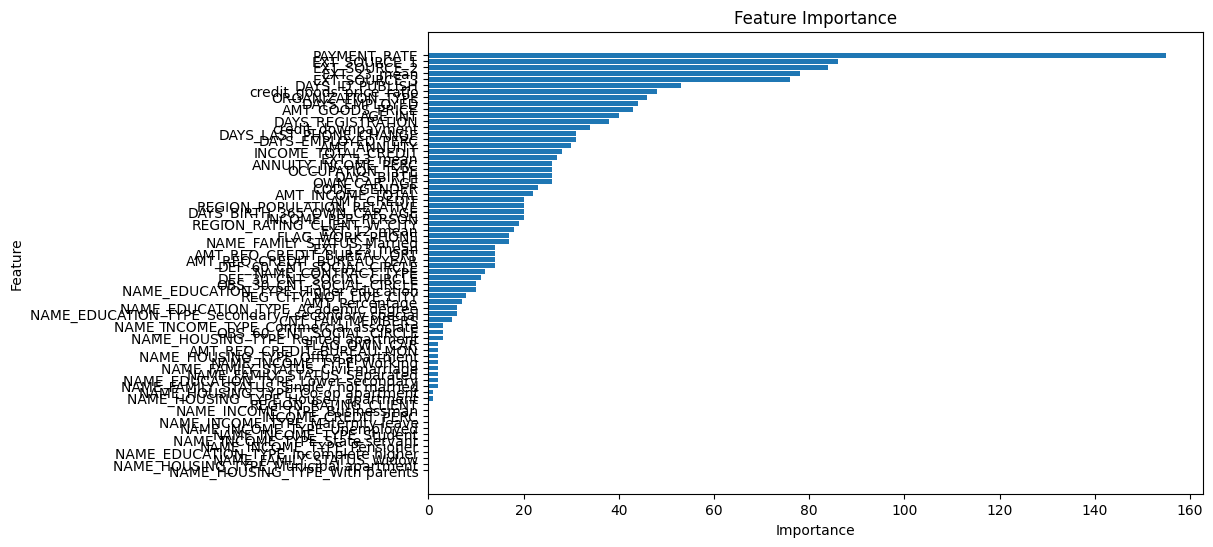

In [69]:
importance = lgb.feature_importances_
feature_names = columns
for feature, imp in zip(feature_names, importance):
    print(f"Feature: {feature}, Importance: {imp}")

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [71]:

for feature, imp in zip(feature_names, importance):
    if imp==0:

        print(f"Feature: {feature}, Importance: {imp}")

Feature: REGION_RATING_CLIENT, Importance: 0
Feature: INCOME_CREDIT_PERC, Importance: 0
Feature: NAME_INCOME_TYPE_Businessman, Importance: 0
Feature: NAME_INCOME_TYPE_Maternity leave, Importance: 0
Feature: NAME_INCOME_TYPE_Pensioner, Importance: 0
Feature: NAME_INCOME_TYPE_State servant, Importance: 0
Feature: NAME_INCOME_TYPE_Student, Importance: 0
Feature: NAME_INCOME_TYPE_Unemployed, Importance: 0
Feature: NAME_EDUCATION_TYPE_Incomplete higher, Importance: 0
Feature: NAME_FAMILY_STATUS_Widow, Importance: 0
Feature: NAME_HOUSING_TYPE_Municipal apartment, Importance: 0
Feature: NAME_HOUSING_TYPE_With parents, Importance: 0


In [34]:
""" NAME_HOUSING_TYPE_Municipal 
NAME_HOUSING_TYPE_Co-op 
NAME_EDUCATION_TYPE_Lower
NAME_EDUCATION_TYPE_Incomplete

NAME_INCOME_TYPE_Businessman
NAME_INCOME_TYPE_Commercial 
NAME_INCOME_TYPE_Maternity 
NAME_INCOME_TYPE_Pensioner
NAME_INCOME_TYPE_Student
NAME_INCOME_TYPE_Unemployed

age_group """

' NAME_HOUSING_TYPE_Municipal \nNAME_HOUSING_TYPE_Co-op \nNAME_EDUCATION_TYPE_Lower\nNAME_EDUCATION_TYPE_Incomplete\n\nNAME_INCOME_TYPE_Businessman\nNAME_INCOME_TYPE_Commercial \nNAME_INCOME_TYPE_Maternity \nNAME_INCOME_TYPE_Pensioner\nNAME_INCOME_TYPE_Student\nNAME_INCOME_TYPE_Unemployed\n\nage_group '

In [35]:
print(df_["NAME_HOUSING_TYPE"].unique())

['House / apartment' 'With parents' 'Rented apartment'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']


# "NAME_INCOME_TYPE"
'Working' 'State servant'  


['Pensioner','Commercial associate','Student','Businessman','Maternity leave','Unemployed']

# "NAME_EDUCATION_TYPE"
'Higher education' 'Secondary / secondary special' 'Academic degree'

['Lower secondary','Incomplete higher'] 

'House / apartment','With parents','Rented apartment','Office apartment' 

 ['Co-op apartment','Municipal apartment'] 

In [34]:
from sklearn.metrics import accuracy_score

In [29]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    Taccuracy = accuracy_score(y_train, y_pred_train)
    accuracy = accuracy_score(y_test, y_pred)
    print(Taccuracy)
    print(accuracy)
    return accuracy

In [30]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)


[I 2024-06-29 17:03:41,505] A new study created in memory with name: no-name-95f42abb-e008-4a66-8fbc-3f3907e587e4
[I 2024-06-29 17:03:42,437] Trial 0 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 0.0016769643896413788, 'lambda_l2': 9.399730539571532e-05, 'num_leaves': 6, 'learning_rate': 0.011100803283051505, 'feature_fraction': 0.677296116757574, 'bagging_fraction': 0.609065075395647, 'bagging_freq': 4, 'min_child_samples': 62}. Best is trial 0 with value: 0.9182266873046933.


0.9195318375303919
0.9182266873046933


[I 2024-06-29 17:03:43,578] Trial 1 finished with value: 0.9125609649250898 and parameters: {'lambda_l1': 1.6099825796331248e-08, 'lambda_l2': 1.5044977001484506e-05, 'num_leaves': 31, 'learning_rate': 0.5715820681339845, 'feature_fraction': 0.4368829012880192, 'bagging_fraction': 0.8117335631563346, 'bagging_freq': 3, 'min_child_samples': 98}. Best is trial 0 with value: 0.9182266873046933.


0.9266506523754937
0.9125609649250898


[I 2024-06-29 17:03:45,122] Trial 2 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 4.3632406455885284e-05, 'lambda_l2': 0.10296929453019621, 'num_leaves': 180, 'learning_rate': 0.00022667078095270484, 'feature_fraction': 0.8974344737269677, 'bagging_fraction': 0.6114146470194852, 'bagging_freq': 7, 'min_child_samples': 36}. Best is trial 0 with value: 0.9182266873046933.


0.9195318375303919
0.9182266873046933


[I 2024-06-29 17:03:46,945] Trial 3 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 0.0031807124175088986, 'lambda_l2': 0.000528061208244448, 'num_leaves': 224, 'learning_rate': 0.0013444491763595894, 'feature_fraction': 0.9015166190561751, 'bagging_fraction': 0.7448457833523057, 'bagging_freq': 5, 'min_child_samples': 32}. Best is trial 0 with value: 0.9182266873046933.


0.9195318375303919
0.9182266873046933


[I 2024-06-29 17:03:48,472] Trial 4 finished with value: 0.9182850968137612 and parameters: {'lambda_l1': 0.00010496375324420229, 'lambda_l2': 0.0030563986127580063, 'num_leaves': 153, 'learning_rate': 0.025242445810846118, 'feature_fraction': 0.42208010950419295, 'bagging_fraction': 0.6796030104497979, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 4 with value: 0.9182850968137612.


0.9198019874270777
0.9182850968137612


[I 2024-06-29 17:03:49,891] Trial 5 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 3.9206386584935564, 'lambda_l2': 2.4390970693693555e-07, 'num_leaves': 103, 'learning_rate': 0.0005605255490329474, 'feature_fraction': 0.9122637843083582, 'bagging_fraction': 0.5174655767076807, 'bagging_freq': 2, 'min_child_samples': 47}. Best is trial 4 with value: 0.9182850968137612.


0.9195318375303919
0.9182266873046933


[I 2024-06-29 17:03:51,809] Trial 6 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 0.23906475474428104, 'lambda_l2': 0.0002000207369026338, 'num_leaves': 202, 'learning_rate': 0.0054551053031033185, 'feature_fraction': 0.7004427961549038, 'bagging_fraction': 0.9490988136687297, 'bagging_freq': 3, 'min_child_samples': 86}. Best is trial 4 with value: 0.9182850968137612.


0.9195318375303919
0.9182266873046933


[I 2024-06-29 17:03:53,407] Trial 7 finished with value: 0.9182850968137612 and parameters: {'lambda_l1': 1.605734585780504e-07, 'lambda_l2': 0.004725398122967824, 'num_leaves': 164, 'learning_rate': 0.01545555743891436, 'feature_fraction': 0.7150827856665346, 'bagging_fraction': 0.6419713830837444, 'bagging_freq': 2, 'min_child_samples': 72}. Best is trial 4 with value: 0.9182850968137612.


0.9195683442731872
0.9182850968137612


[I 2024-06-29 17:03:55,438] Trial 8 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 0.12311109983187679, 'lambda_l2': 4.6126012050765764e-08, 'num_leaves': 249, 'learning_rate': 0.00020964451607669347, 'feature_fraction': 0.9346915840707118, 'bagging_fraction': 0.8493717061890451, 'bagging_freq': 7, 'min_child_samples': 57}. Best is trial 4 with value: 0.9182850968137612.


0.9195318375303919
0.9182266873046933


[I 2024-06-29 17:03:56,706] Trial 9 finished with value: 0.914313250197132 and parameters: {'lambda_l1': 1.2126756288973475e-06, 'lambda_l2': 8.748324973020317, 'num_leaves': 69, 'learning_rate': 0.29170778195882757, 'feature_fraction': 0.940227900232739, 'bagging_fraction': 0.42607289016132494, 'bagging_freq': 2, 'min_child_samples': 73}. Best is trial 4 with value: 0.9182850968137612.


0.9277604573564737
0.914313250197132


[I 2024-06-29 17:03:58,187] Trial 10 finished with value: 0.9185771443591016 and parameters: {'lambda_l1': 4.4256342148518235e-05, 'lambda_l2': 0.12884324982666187, 'num_leaves': 134, 'learning_rate': 0.07299211889059545, 'feature_fraction': 0.4050178458297255, 'bagging_fraction': 0.9671093602884333, 'bagging_freq': 5, 'min_child_samples': 5}. Best is trial 10 with value: 0.9185771443591016.


0.9229050605646864
0.9185771443591016


[I 2024-06-29 17:03:59,632] Trial 11 finished with value: 0.9182850968137612 and parameters: {'lambda_l1': 2.3749416482057852e-05, 'lambda_l2': 0.1426424805985185, 'num_leaves': 132, 'learning_rate': 0.0755262344023358, 'feature_fraction': 0.4004163892830596, 'bagging_fraction': 0.9338589618428399, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 10 with value: 0.9185771443591016.


0.9234891684494126
0.9182850968137612


[I 2024-06-29 17:04:01,231] Trial 12 finished with value: 0.9181974825501592 and parameters: {'lambda_l1': 9.91711606812875e-06, 'lambda_l2': 0.06022393333568643, 'num_leaves': 133, 'learning_rate': 0.05634318638632246, 'feature_fraction': 0.5177317147793052, 'bagging_fraction': 0.9999427191392138, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 10 with value: 0.9185771443591016.


0.92232095267996
0.9181974825501592


[I 2024-06-29 17:04:02,612] Trial 13 finished with value: 0.9186647586227038 and parameters: {'lambda_l1': 0.00035240278276659967, 'lambda_l2': 3.3602464271941526, 'num_leaves': 84, 'learning_rate': 0.05337961575790194, 'feature_fraction': 0.539258644115885, 'bagging_fraction': 0.7243925148353267, 'bagging_freq': 4, 'min_child_samples': 23}. Best is trial 13 with value: 0.9186647586227038.


0.9206343411628127
0.9186647586227038


[I 2024-06-29 17:04:03,919] Trial 14 finished with value: 0.9185479396045676 and parameters: {'lambda_l1': 0.0031532468304995977, 'lambda_l2': 9.533731519307514, 'num_leaves': 71, 'learning_rate': 0.20958495230512716, 'feature_fraction': 0.5584627000476718, 'bagging_fraction': 0.8495035761865669, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 13 with value: 0.9186647586227038.


0.9243361248822658
0.9185479396045676


[I 2024-06-29 17:04:05,346] Trial 15 finished with value: 0.9182266873046933 and parameters: {'lambda_l1': 9.854492666601922e-07, 'lambda_l2': 0.48059777743247073, 'num_leaves': 93, 'learning_rate': 0.0030780398991018345, 'feature_fraction': 0.5592674172012356, 'bagging_fraction': 0.786550860030072, 'bagging_freq': 4, 'min_child_samples': 6}. Best is trial 13 with value: 0.9186647586227038.


0.9195318375303919
0.9182266873046933


[I 2024-06-29 17:04:06,427] Trial 16 finished with value: 0.9183727110773634 and parameters: {'lambda_l1': 0.0005353289803494577, 'lambda_l2': 0.6125430287387245, 'num_leaves': 56, 'learning_rate': 0.09391933615382224, 'feature_fraction': 0.49593401991153474, 'bagging_fraction': 0.5294874713844028, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 13 with value: 0.9186647586227038.


0.9217514474923518
0.9183727110773634


[I 2024-06-29 17:04:07,558] Trial 17 finished with value: 0.8763762740574166 and parameters: {'lambda_l1': 0.02508810647494194, 'lambda_l2': 0.008264650568402419, 'num_leaves': 105, 'learning_rate': 0.8958232691061596, 'feature_fraction': 0.6038129732789932, 'bagging_fraction': 0.8855750452630369, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 13 with value: 0.9186647586227038.


0.9095727980958083
0.8763762740574166


[I 2024-06-29 17:04:08,596] Trial 18 finished with value: 0.9182850968137612 and parameters: {'lambda_l1': 3.621892979098701e-06, 'lambda_l2': 1.706249171327399, 'num_leaves': 33, 'learning_rate': 0.030062977086675925, 'feature_fraction': 0.7958363239453482, 'bagging_fraction': 0.7350447651497992, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 13 with value: 0.9186647586227038.


0.9196194537131008
0.9182850968137612


[I 2024-06-29 17:04:09,822] Trial 19 finished with value: 0.9145760929879384 and parameters: {'lambda_l1': 0.00024386193627335518, 'lambda_l2': 3.8404256989103024e-06, 'num_leaves': 117, 'learning_rate': 0.19879913586973644, 'feature_fraction': 0.4748610586013574, 'bagging_fraction': 0.5427897558351147, 'bagging_freq': 4, 'min_child_samples': 18}. Best is trial 13 with value: 0.9186647586227038.


0.9361716108965326
0.9145760929879384


In [31]:
print('Best trial:')
trial = study.best_trial
print('Accuracy:', trial.value)
print("Best hyperparameters:", trial.params)


Best trial:
Accuracy: 0.9186647586227038
Best hyperparameters: {'lambda_l1': 0.00035240278276659967, 'lambda_l2': 3.3602464271941526, 'num_leaves': 84, 'learning_rate': 0.05337961575790194, 'feature_fraction': 0.539258644115885, 'bagging_fraction': 0.7243925148353267, 'bagging_freq': 4, 'min_child_samples': 23}


In [52]:
pred = lgb.predict_proba(Test_X)[:, 1]
sample_sub['TARGET'] = pred
sample_sub

,SK_ID_CURR,TARGET
0,171202,0.036467
1,171203,0.138207
2,171204,0.116968
3,171205,0.092987
4,171206,0.187169
...,...,...
61495,232697,0.139397
61496,232698,0.044381
61497,232699,0.054374
61498,232700,0.128366


In [53]:
sample_sub.to_csv("lgb.csv", index=False)


# ORGANIZATION_TYPE

# site

https://toshikishimizu.hatenablog.com/entry/2018/09/16/113851#%E3%82%B3%E3%83%B3%E3%83%9A%E3%81%AE%E6%A6%82%E8%A6%81

https://data-analysis-stats.jp/kaggle/kaggle1%e4%bd%8d%e3%81%ae%e8%a7%a3%e6%9e%90%e6%89%8b%e6%b3%95%e3%80%80%e3%80%8chome-credit-default-risk-%e5%82%b5%e5%8b%99%e4%b8%8d%e5%b1%a5%e8%a1%8c%e3%81%ae%e4%ba%88%e6%b8%ac%e3%80%8d%e2%91%a1/

https://www.kaggle.com/code/ogrellier/good-fun-with-ligthgbm

In [ ]:
# heatmap
#smote
#parameter tuning